# Inferring spot latitudes 

In the [Quickstart](Quickstart.ipynb) tutorial, we showed how to infer the radii of the star spots in a (very simple) example. In this notebook we'll discuss how to infer the parameters controlling their distribution in latitude.

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Disable annoying font warnings
matplotlib.font_manager._log.setLevel(50)

# Disable theano deprecation warnings
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="theano")

# Style
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = False
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["font.cursive"] = ["Liberation Sans"]
try:
    plt.rcParams["mathtext.fallback"] = "cm"
except KeyError:
    plt.rcParams["mathtext.fallback_to_cm"] = True
plt.rcParams["mathtext.fallback_to_cm"] = True

# Short arrays when printing
np.set_printoptions(threshold=0)

In [4]:
del matplotlib
del plt
del warnings

## Setup

Let's import some basic stuff. We'll use the `emcee` package to run our MCMC analyses below.

In [5]:
from starry_process import StarryProcess, beta2gauss
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import theano
import theano.tensor as tt
import emcee
from corner import corner

We'll instantiate a `StarryProcess` with high-latitude spots at $\phi = 60^\circ \pm 5^\circ$:

In [6]:
truths = [60.0, 5.0]
sp = StarryProcess(mu=truths[0], sigma=truths[1])

Here's what a random sample from the process looks like on the surface of the star:

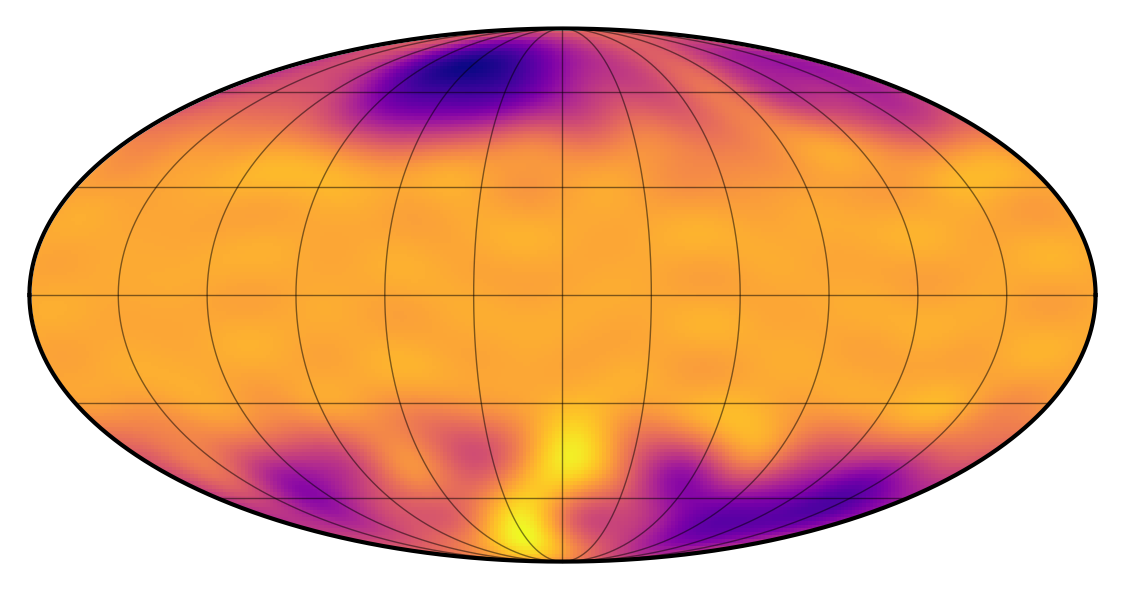

In [7]:
sp.visualize()

To start us off, let's draw 50 light curve samples from the process:

In [8]:
t = np.linspace(0, 4, 500)
flux = sp.sample(t, nsamples=50).eval()
flux.shape

(50, 500)

All samples have the same rotation period (`1.0` day by default), and we're computing the light curves over 4 rotations. Since by default `StarryProcess` marginalizes over inclination, these samples correspond to random inclinations drawn from an isotropic distribution. Let's visualize all of them:

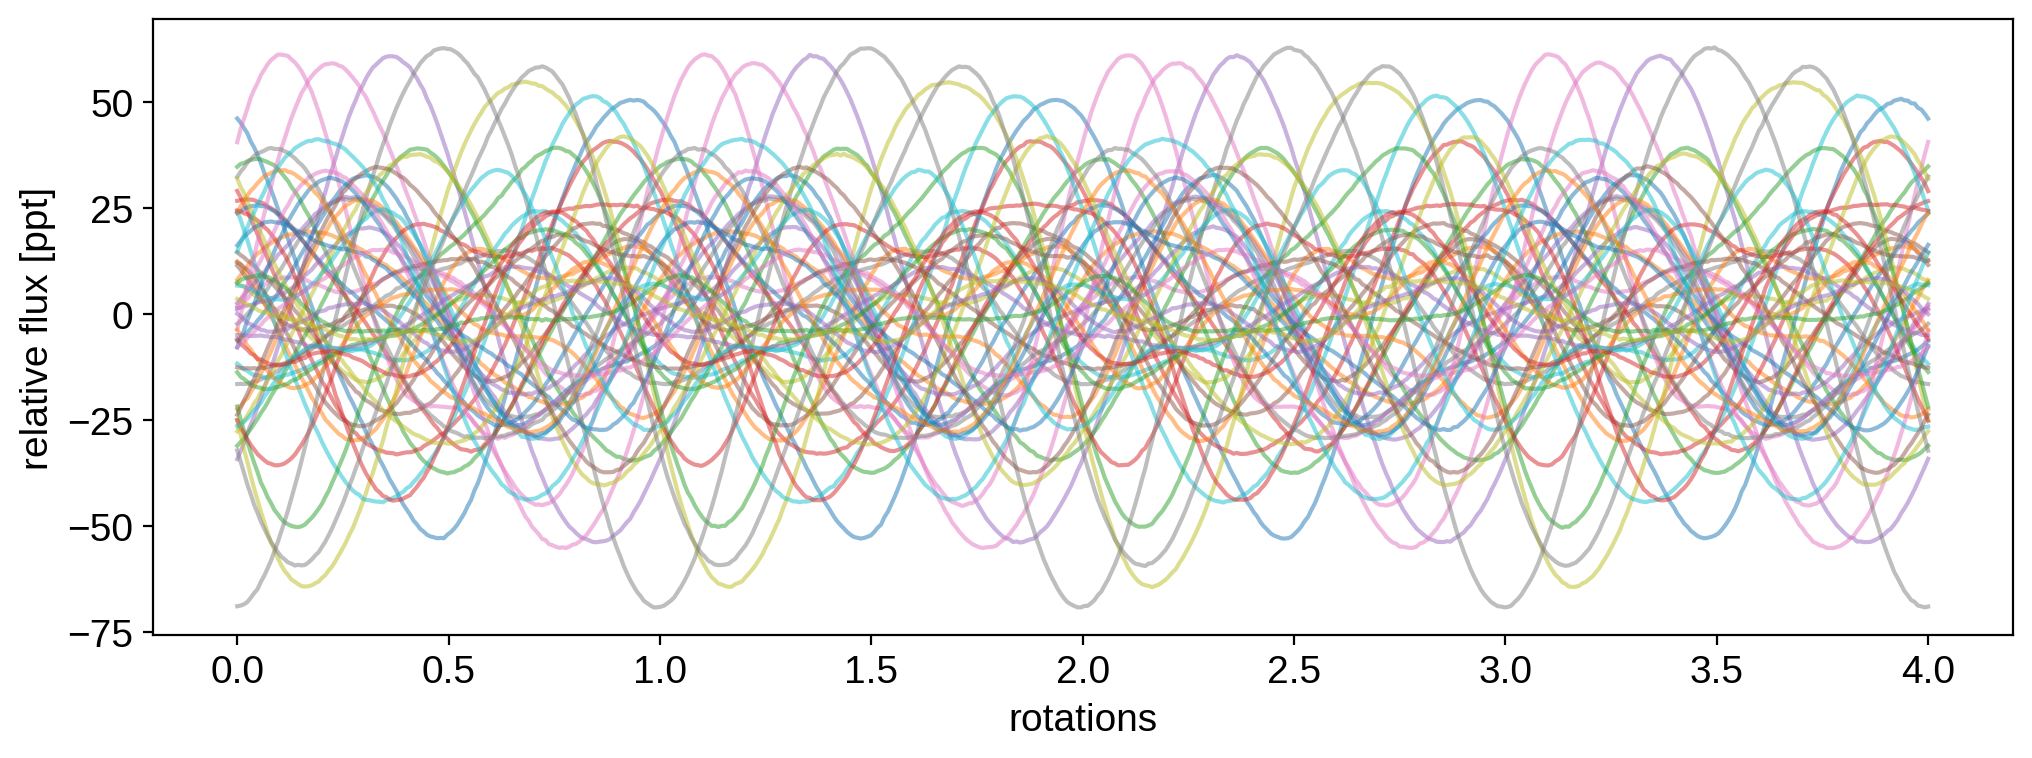

In [9]:
for k in range(50):
    plt.plot(t, 1e3 * flux[k], alpha=0.5)
plt.xlabel("rotations")
plt.ylabel("relative flux [ppt]")
plt.show()

Since we're going to do inference, we need to add a bit of observational noise to these samples to mimic actual observations. Here's what the first light curve looks like:

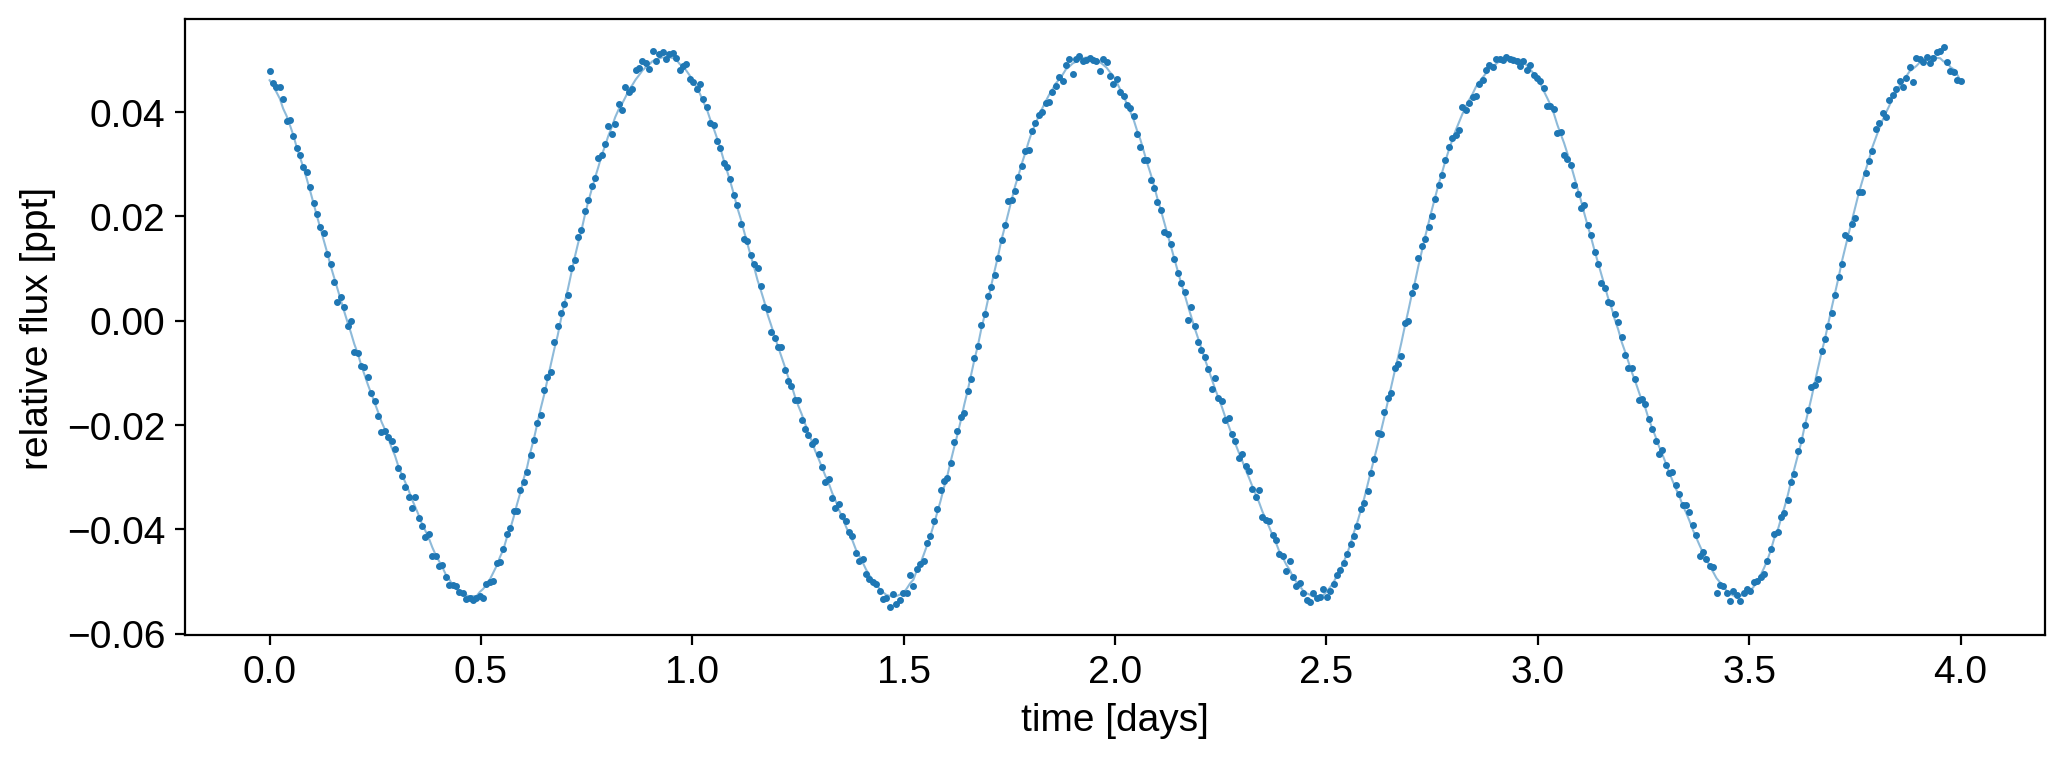

In [10]:
ferr = 1e-3
np.random.seed(0)
f = flux + ferr * np.random.randn(50, len(t))
plt.plot(t, flux[0], "C0-", lw=0.75, alpha=0.5)
plt.plot(t, f[0], "C0.", ms=3)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.show()

## MCMC

Given these 50 light curves, our task now is to infer the mean and standard deviation of the spot latitude distribution. For simplicity, we'll assume we know everything else: the spot radius, contrast, number of spots, and stellar rotation period (but not the inclinations). That makes the inference problem 2-dimensional and thus fast to run.

A few notes about this. First, the spot latitude distribution assumed internally is *not* a Gaussian. It's a Beta distribution in the cosine of the latitude, which in certain limits *looks* a lot like a bimodal Gaussian, with a mode at $+\mu_\sigma$ and a mode at $-\mu_\sigma$. The parameters of this distribution are the *mode* `mu` and the local standard deviation at the mode *sigma*, which in many cases are good approximations to the mean and standard deviation of the closest-matching Gaussian. The reason for this is explained in the paper: the adopted distribution and parametrization admits a **closed-form solution** to the mean and covariance of the GP, which is at the heart of why `starry_process` is so fast.

For reference, you can compute the actual distribution assumed internally by calling

```python
sp.latitude.pdf(phi)
```

where `sp` is an instance of `StarryProcess` (with certain values of `mu` and `sigma`), and `phi` is the latitude(s) in degrees at which to compute the probability density function (PDF). Here's the distribution we used to generate the light curve samples:

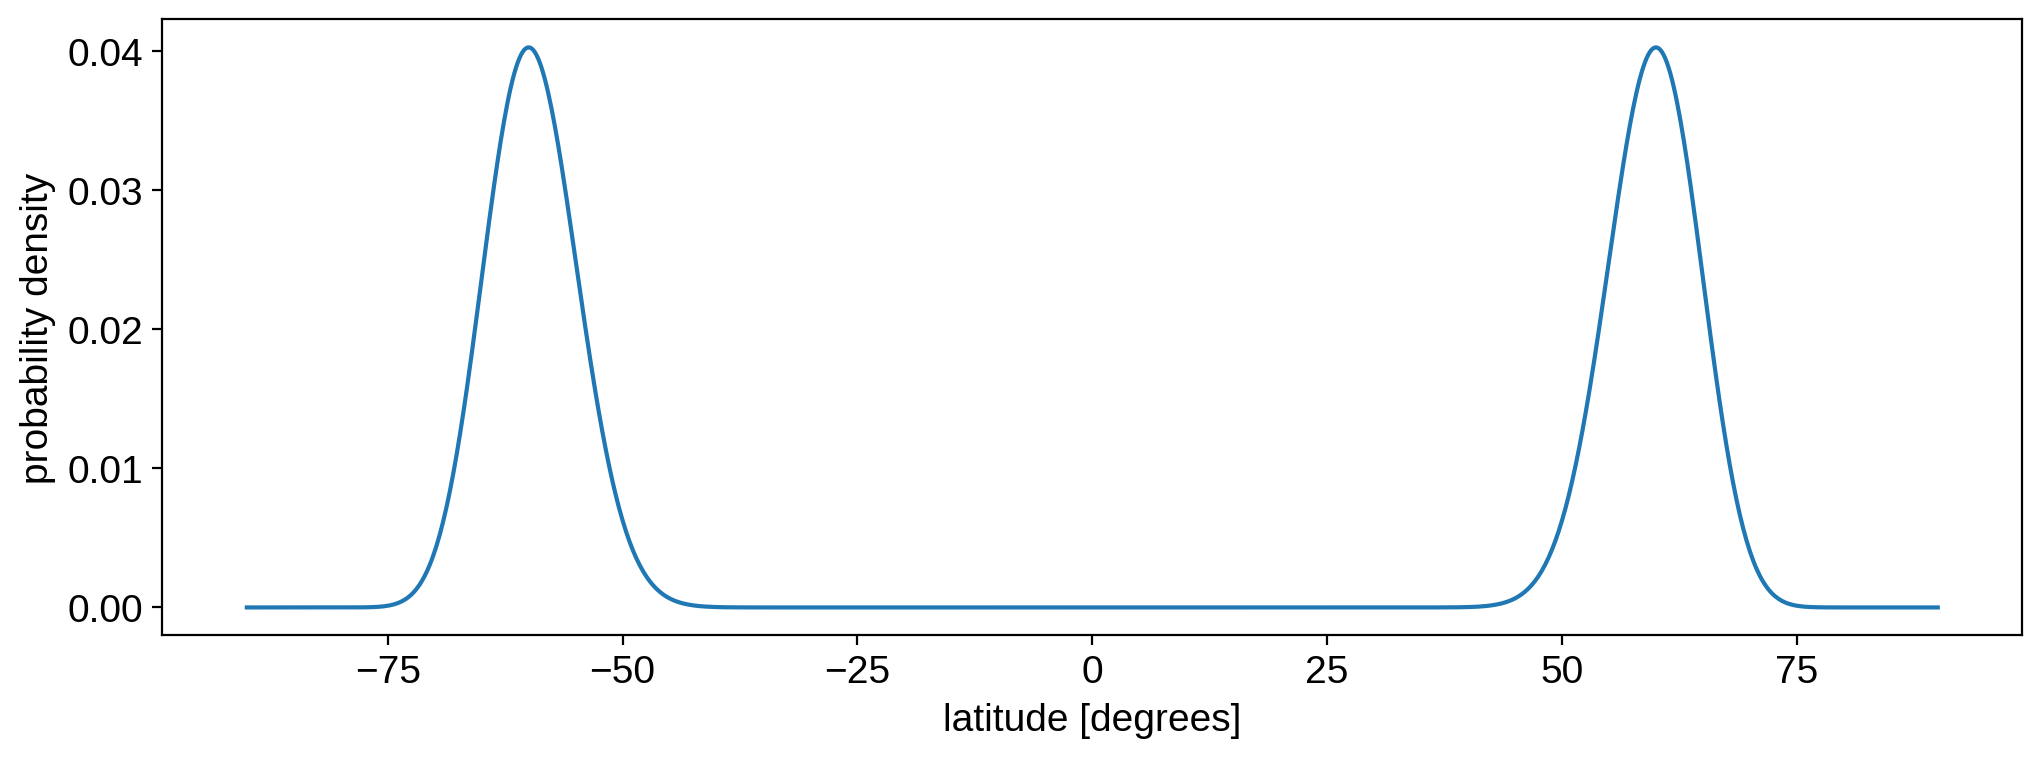

In [11]:
phi = np.linspace(-90, 90, 1000)
pdf = sp.latitude.pdf(phi).eval()
plt.plot(phi, pdf)
plt.xlabel("latitude [degrees]")
plt.ylabel("probability density")
plt.show()

As promised, it looks a *lot* like a bimodal Gaussian with mean `mu = 60` and standard deviation `sigma = 5`. Typically, this distribution deviates from a Gaussian when either `mu` or `sigma` get very large.

The other thing to note before we do inference is that there are two ways of proceeding. We can either sample in the parameters `mu` and `sigma` *or* in the dimensionless parameters `a` and `b`. In most cases we'll get the same answer (provided we account for the Jacobian of the transformation), but we recommend the latter as it's guaranteed to be numerically stable. That's because there are certain combinations of `mu` and `sigma` that lead to *very* large coefficients in the evaluation of the integrals of the Beta distribution. This usually happens when `sigma` is very small (less than 1 or 2 degrees) or `mu` is very large (larger than 85 degrees). Sometimes this can raise errors in the likelihood evaluation (which can be caught in a `try...except` block), but sometimes it can just silently lead to the wrong value of the likelihood. The latter can be avoided by limiting the prior bounds on these two quantities. We do this below, and show that for this specific example, it works great! 

However, a better approach is to sample in the dimensionless parameters `a` and `b`, which both have support in `[0, 1]`, then transform the posterior constraints on these parameters into constraints on `mu` and `sigma`. Sampling in this space is much, much more likely to work seamlessly. We'll discuss how to do this below. But first, let's show how to sample in `mu` and `sigma` directly.

### Sampling in `mu`, `sigma`

As in the [Quickstart](Quickstart.ipynb) tutorial, we need to compile our likelihood function. We'll make it a function of the scalars `mu` and `sigma`, and bake in the time array `t`, the batch of light curves `f`, and the photometric uncertainty `ferr` (as well as all the other default hyperparameter values).

In [12]:
mu_tensor = tt.dscalar()
sigma_tensor = tt.dscalar()
log_likelihood1 = theano.function(
    [mu_tensor, sigma_tensor],
    StarryProcess(mu=mu_tensor, sigma=sigma_tensor).log_likelihood(t, f, ferr ** 2),
)

We can now construct our log probability function (the sum of the log likelihood and the log prior). Let's adopt the simplest possible prior: a uniform distribution for `mu` and `sigma` that avoids the unstable values discssued above. We'll draw from this prior to obtain our initial sampling point, `p0`:

In [13]:
def log_prob1(x):
    mu, sigma = x
    if (mu < 0) or (mu > 85):
        return -np.inf
    elif (sigma < 1) or (sigma > 30):
        return -np.inf
    return log_likelihood1(mu, sigma)


ndim, nwalkers = 2, 6
p0 = np.transpose(
    [np.random.uniform(0, 85, size=nwalkers), np.random.uniform(1, 30, size=nwalkers)]
)

Now we can instantiate a sampler (using `emcee`) and run it. We'll do 1000 steps with 6 walkers:

In [14]:
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, log_prob1)
_ = sampler1.run_mcmc(p0, 1000, progress=True)
chain1 = np.array(sampler1.chain)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<02:22,  6.99it/s]

  0%|          | 2/1000 [00:00<02:55,  5.69it/s]

  0%|          | 3/1000 [00:00<03:25,  4.86it/s]

  0%|          | 4/1000 [00:00<03:39,  4.54it/s]

  0%|          | 5/1000 [00:01<03:46,  4.38it/s]

  1%|          | 6/1000 [00:01<03:50,  4.32it/s]

  1%|          | 7/1000 [00:01<04:09,  3.98it/s]

  1%|          | 8/1000 [00:01<04:19,  3.82it/s]

  1%|          | 9/1000 [00:02<04:11,  3.93it/s]

  1%|          | 10/1000 [00:02<04:22,  3.77it/s]

  1%|          | 11/1000 [00:02<04:30,  3.65it/s]

  1%|          | 12/1000 [00:02<04:33,  3.61it/s]

  1%|▏         | 13/1000 [00:03<04:22,  3.76it/s]

  1%|▏         | 14/1000 [00:03<04:15,  3.86it/s]

  2%|▏         | 15/1000 [00:03<03:55,  4.19it/s]

  2%|▏         | 16/1000 [00:03<04:09,  3.94it/s]

  2%|▏         | 17/1000 [00:04<04:05,  4.00it/s]

  2%|▏         | 18/1000 [00:04<04:02,  4.04it/s]

  2%|▏         | 19/1000 [00:04<04:13,  3.87it/s]

  2%|▏         | 20/1000 [00:05<04:21,  3.75it/s]

  2%|▏         | 21/1000 [00:05<04:26,  3.68it/s]

  2%|▏         | 22/1000 [00:05<04:31,  3.61it/s]

  2%|▏         | 23/1000 [00:05<04:36,  3.54it/s]

  2%|▏         | 24/1000 [00:06<04:37,  3.52it/s]

  2%|▎         | 25/1000 [00:06<04:39,  3.49it/s]

  3%|▎         | 26/1000 [00:06<04:40,  3.48it/s]

  3%|▎         | 27/1000 [00:07<04:40,  3.47it/s]

  3%|▎         | 28/1000 [00:07<04:39,  3.48it/s]

  3%|▎         | 29/1000 [00:07<04:39,  3.47it/s]

  3%|▎         | 30/1000 [00:07<04:24,  3.67it/s]

  3%|▎         | 31/1000 [00:08<04:14,  3.81it/s]

  3%|▎         | 32/1000 [00:08<04:20,  3.72it/s]

  3%|▎         | 33/1000 [00:08<04:12,  3.84it/s]

  3%|▎         | 34/1000 [00:08<04:09,  3.88it/s]

  4%|▎         | 35/1000 [00:09<04:02,  3.97it/s]

  4%|▎         | 36/1000 [00:09<03:58,  4.05it/s]

  4%|▎         | 37/1000 [00:09<03:40,  4.37it/s]

  4%|▍         | 38/1000 [00:09<03:54,  4.10it/s]

  4%|▍         | 39/1000 [00:10<04:07,  3.89it/s]

  4%|▍         | 40/1000 [00:10<04:15,  3.76it/s]

  4%|▍         | 41/1000 [00:10<04:20,  3.68it/s]

  4%|▍         | 42/1000 [00:10<04:10,  3.83it/s]

  4%|▍         | 43/1000 [00:11<04:16,  3.74it/s]

  4%|▍         | 44/1000 [00:11<04:20,  3.66it/s]

  4%|▍         | 45/1000 [00:11<04:25,  3.60it/s]

  5%|▍         | 46/1000 [00:12<04:27,  3.57it/s]

  5%|▍         | 47/1000 [00:12<04:29,  3.53it/s]

  5%|▍         | 48/1000 [00:12<04:30,  3.52it/s]

  5%|▍         | 49/1000 [00:12<04:16,  3.70it/s]

  5%|▌         | 50/1000 [00:13<04:20,  3.65it/s]

  5%|▌         | 51/1000 [00:13<04:09,  3.80it/s]

  5%|▌         | 52/1000 [00:13<04:16,  3.70it/s]

  5%|▌         | 53/1000 [00:13<04:06,  3.84it/s]

  5%|▌         | 54/1000 [00:14<04:14,  3.72it/s]

  6%|▌         | 55/1000 [00:14<04:18,  3.66it/s]

  6%|▌         | 56/1000 [00:14<04:25,  3.56it/s]

  6%|▌         | 57/1000 [00:15<04:26,  3.54it/s]

  6%|▌         | 58/1000 [00:15<04:26,  3.53it/s]

  6%|▌         | 59/1000 [00:15<04:26,  3.53it/s]

  6%|▌         | 60/1000 [00:15<04:26,  3.52it/s]

  6%|▌         | 61/1000 [00:16<04:26,  3.52it/s]

  6%|▌         | 62/1000 [00:16<04:27,  3.50it/s]

  6%|▋         | 63/1000 [00:16<04:30,  3.47it/s]

  6%|▋         | 64/1000 [00:17<04:29,  3.48it/s]

  6%|▋         | 65/1000 [00:17<04:15,  3.66it/s]

  7%|▋         | 66/1000 [00:17<04:18,  3.62it/s]

  7%|▋         | 67/1000 [00:17<04:19,  3.59it/s]

  7%|▋         | 68/1000 [00:18<04:08,  3.75it/s]

  7%|▋         | 69/1000 [00:18<04:00,  3.87it/s]

  7%|▋         | 70/1000 [00:18<03:53,  3.98it/s]

  7%|▋         | 71/1000 [00:18<04:02,  3.83it/s]

  7%|▋         | 72/1000 [00:19<03:56,  3.92it/s]

  7%|▋         | 73/1000 [00:19<03:40,  4.20it/s]

  7%|▋         | 74/1000 [00:19<03:53,  3.96it/s]

  8%|▊         | 75/1000 [00:19<04:03,  3.80it/s]

  8%|▊         | 76/1000 [00:20<04:10,  3.68it/s]

  8%|▊         | 77/1000 [00:20<04:15,  3.61it/s]

  8%|▊         | 78/1000 [00:20<04:24,  3.48it/s]

  8%|▊         | 79/1000 [00:21<04:24,  3.48it/s]

  8%|▊         | 80/1000 [00:21<04:24,  3.47it/s]

  8%|▊         | 81/1000 [00:21<04:23,  3.49it/s]

  8%|▊         | 82/1000 [00:21<04:22,  3.49it/s]

  8%|▊         | 83/1000 [00:22<04:23,  3.49it/s]

  8%|▊         | 84/1000 [00:22<04:21,  3.50it/s]

  8%|▊         | 85/1000 [00:22<04:08,  3.68it/s]

  9%|▊         | 86/1000 [00:23<04:10,  3.64it/s]

  9%|▊         | 87/1000 [00:23<03:59,  3.81it/s]

  9%|▉         | 88/1000 [00:23<03:51,  3.94it/s]

  9%|▉         | 89/1000 [00:23<04:00,  3.79it/s]

  9%|▉         | 90/1000 [00:24<04:07,  3.68it/s]

  9%|▉         | 91/1000 [00:24<04:14,  3.58it/s]

  9%|▉         | 92/1000 [00:24<04:16,  3.54it/s]

  9%|▉         | 93/1000 [00:24<04:18,  3.51it/s]

  9%|▉         | 94/1000 [00:25<04:19,  3.49it/s]

 10%|▉         | 95/1000 [00:25<04:06,  3.68it/s]

 10%|▉         | 96/1000 [00:25<04:11,  3.60it/s]

 10%|▉         | 97/1000 [00:26<04:12,  3.57it/s]

 10%|▉         | 98/1000 [00:26<04:02,  3.73it/s]

 10%|▉         | 99/1000 [00:26<03:53,  3.87it/s]

 10%|█         | 100/1000 [00:26<03:48,  3.93it/s]

 10%|█         | 101/1000 [00:27<03:47,  3.96it/s]

 10%|█         | 102/1000 [00:27<03:57,  3.78it/s]

 10%|█         | 103/1000 [00:27<04:02,  3.70it/s]

 10%|█         | 104/1000 [00:27<04:06,  3.64it/s]

 10%|█         | 105/1000 [00:28<04:08,  3.60it/s]

 11%|█         | 106/1000 [00:28<04:11,  3.56it/s]

 11%|█         | 107/1000 [00:28<04:12,  3.54it/s]

 11%|█         | 108/1000 [00:28<04:00,  3.72it/s]

 11%|█         | 109/1000 [00:29<04:04,  3.65it/s]

 11%|█         | 110/1000 [00:29<04:06,  3.61it/s]

 11%|█         | 111/1000 [00:29<04:07,  3.59it/s]

 11%|█         | 112/1000 [00:30<04:07,  3.58it/s]

 11%|█▏        | 113/1000 [00:30<04:10,  3.55it/s]

 11%|█▏        | 114/1000 [00:30<04:12,  3.50it/s]

 12%|█▏        | 115/1000 [00:30<04:13,  3.48it/s]

 12%|█▏        | 116/1000 [00:31<04:13,  3.49it/s]

 12%|█▏        | 117/1000 [00:31<04:11,  3.51it/s]

 12%|█▏        | 118/1000 [00:31<04:10,  3.52it/s]

 12%|█▏        | 119/1000 [00:32<04:10,  3.51it/s]

 12%|█▏        | 120/1000 [00:32<04:12,  3.49it/s]

 12%|█▏        | 121/1000 [00:32<04:10,  3.51it/s]

 12%|█▏        | 122/1000 [00:32<04:11,  3.49it/s]

 12%|█▏        | 123/1000 [00:33<04:12,  3.48it/s]

 12%|█▏        | 124/1000 [00:33<03:59,  3.66it/s]

 12%|█▎        | 125/1000 [00:33<04:02,  3.61it/s]

 13%|█▎        | 126/1000 [00:34<04:03,  3.59it/s]

 13%|█▎        | 127/1000 [00:34<04:05,  3.56it/s]

 13%|█▎        | 128/1000 [00:34<04:06,  3.54it/s]

 13%|█▎        | 129/1000 [00:34<04:08,  3.50it/s]

 13%|█▎        | 130/1000 [00:35<04:07,  3.52it/s]

 13%|█▎        | 131/1000 [00:35<03:56,  3.68it/s]

 13%|█▎        | 132/1000 [00:35<04:00,  3.61it/s]

 13%|█▎        | 133/1000 [00:35<03:51,  3.75it/s]

 13%|█▎        | 134/1000 [00:36<03:42,  3.89it/s]

 14%|█▎        | 135/1000 [00:36<03:50,  3.76it/s]

 14%|█▎        | 136/1000 [00:36<03:55,  3.66it/s]

 14%|█▎        | 137/1000 [00:37<03:58,  3.61it/s]

 14%|█▍        | 138/1000 [00:37<03:49,  3.75it/s]

 14%|█▍        | 139/1000 [00:37<03:42,  3.86it/s]

 14%|█▍        | 140/1000 [00:37<03:48,  3.77it/s]

 14%|█▍        | 141/1000 [00:38<03:41,  3.89it/s]

 14%|█▍        | 142/1000 [00:38<03:35,  3.98it/s]

 14%|█▍        | 143/1000 [00:38<03:31,  4.04it/s]

 14%|█▍        | 144/1000 [00:38<03:41,  3.86it/s]

 14%|█▍        | 145/1000 [00:39<03:53,  3.67it/s]

 15%|█▍        | 146/1000 [00:39<03:57,  3.59it/s]

 15%|█▍        | 147/1000 [00:39<03:47,  3.75it/s]

 15%|█▍        | 148/1000 [00:39<03:51,  3.68it/s]

 15%|█▍        | 149/1000 [00:40<03:56,  3.61it/s]

 15%|█▌        | 150/1000 [00:40<03:45,  3.77it/s]

 15%|█▌        | 151/1000 [00:40<03:50,  3.69it/s]

 15%|█▌        | 152/1000 [00:41<03:53,  3.63it/s]

 15%|█▌        | 153/1000 [00:41<03:44,  3.77it/s]

 15%|█▌        | 154/1000 [00:41<03:48,  3.70it/s]

 16%|█▌        | 155/1000 [00:41<03:54,  3.60it/s]

 16%|█▌        | 156/1000 [00:42<03:56,  3.56it/s]

 16%|█▌        | 157/1000 [00:42<03:58,  3.53it/s]

 16%|█▌        | 158/1000 [00:42<03:59,  3.51it/s]

 16%|█▌        | 159/1000 [00:42<03:48,  3.68it/s]

 16%|█▌        | 160/1000 [00:43<03:53,  3.60it/s]

 16%|█▌        | 161/1000 [00:43<03:55,  3.56it/s]

 16%|█▌        | 162/1000 [00:43<03:56,  3.54it/s]

 16%|█▋        | 163/1000 [00:44<03:58,  3.52it/s]

 16%|█▋        | 164/1000 [00:44<03:58,  3.51it/s]

 16%|█▋        | 165/1000 [00:44<03:57,  3.51it/s]

 17%|█▋        | 166/1000 [00:45<04:00,  3.47it/s]

 17%|█▋        | 167/1000 [00:45<04:00,  3.47it/s]

 17%|█▋        | 168/1000 [00:45<04:01,  3.45it/s]

 17%|█▋        | 169/1000 [00:45<03:59,  3.46it/s]

 17%|█▋        | 170/1000 [00:46<03:59,  3.47it/s]

 17%|█▋        | 171/1000 [00:46<03:59,  3.47it/s]

 17%|█▋        | 172/1000 [00:46<03:58,  3.47it/s]

 17%|█▋        | 173/1000 [00:47<03:57,  3.48it/s]

 17%|█▋        | 174/1000 [00:47<03:57,  3.48it/s]

 18%|█▊        | 175/1000 [00:47<03:55,  3.50it/s]

 18%|█▊        | 176/1000 [00:47<03:32,  3.88it/s]

 18%|█▊        | 177/1000 [00:48<03:38,  3.77it/s]

 18%|█▊        | 178/1000 [00:48<03:42,  3.69it/s]

 18%|█▊        | 179/1000 [00:48<03:34,  3.82it/s]

 18%|█▊        | 180/1000 [00:48<03:40,  3.71it/s]

 18%|█▊        | 181/1000 [00:49<03:46,  3.62it/s]

 18%|█▊        | 182/1000 [00:49<03:49,  3.56it/s]

 18%|█▊        | 183/1000 [00:49<03:51,  3.53it/s]

 18%|█▊        | 184/1000 [00:50<03:51,  3.53it/s]

 18%|█▊        | 185/1000 [00:50<03:51,  3.52it/s]

 19%|█▊        | 186/1000 [00:50<03:40,  3.69it/s]

 19%|█▊        | 187/1000 [00:50<03:44,  3.62it/s]

 19%|█▉        | 188/1000 [00:51<03:37,  3.73it/s]

 19%|█▉        | 189/1000 [00:51<03:31,  3.84it/s]

 19%|█▉        | 190/1000 [00:51<03:24,  3.96it/s]

 19%|█▉        | 191/1000 [00:51<03:20,  4.03it/s]

 19%|█▉        | 192/1000 [00:52<03:18,  4.06it/s]

 19%|█▉        | 193/1000 [00:52<03:17,  4.09it/s]

 19%|█▉        | 194/1000 [00:52<03:16,  4.10it/s]

 20%|█▉        | 195/1000 [00:52<03:16,  4.10it/s]

 20%|█▉        | 196/1000 [00:53<03:15,  4.12it/s]

 20%|█▉        | 197/1000 [00:53<03:15,  4.12it/s]

 20%|█▉        | 198/1000 [00:53<03:13,  4.14it/s]

 20%|█▉        | 199/1000 [00:53<03:13,  4.14it/s]

 20%|██        | 200/1000 [00:53<03:12,  4.15it/s]

 20%|██        | 201/1000 [00:54<03:11,  4.18it/s]

 20%|██        | 202/1000 [00:54<03:21,  3.95it/s]

 20%|██        | 203/1000 [00:54<03:29,  3.81it/s]

 20%|██        | 204/1000 [00:55<03:34,  3.71it/s]

 20%|██        | 205/1000 [00:55<03:38,  3.64it/s]

 21%|██        | 206/1000 [00:55<03:29,  3.79it/s]

 21%|██        | 207/1000 [00:55<03:33,  3.72it/s]

 21%|██        | 208/1000 [00:56<03:35,  3.68it/s]

 21%|██        | 209/1000 [00:56<03:38,  3.63it/s]

 21%|██        | 210/1000 [00:56<03:40,  3.57it/s]

 21%|██        | 211/1000 [00:57<03:43,  3.53it/s]

 21%|██        | 212/1000 [00:57<03:43,  3.52it/s]

 21%|██▏       | 213/1000 [00:57<03:43,  3.52it/s]

 21%|██▏       | 214/1000 [00:57<03:42,  3.53it/s]

 22%|██▏       | 215/1000 [00:58<03:42,  3.53it/s]

 22%|██▏       | 216/1000 [00:58<03:42,  3.52it/s]

 22%|██▏       | 217/1000 [00:58<03:42,  3.52it/s]

 22%|██▏       | 218/1000 [00:59<03:41,  3.53it/s]

 22%|██▏       | 219/1000 [00:59<03:42,  3.51it/s]

 22%|██▏       | 220/1000 [00:59<03:42,  3.50it/s]

 22%|██▏       | 221/1000 [00:59<03:41,  3.51it/s]

 22%|██▏       | 222/1000 [01:00<03:40,  3.52it/s]

 22%|██▏       | 223/1000 [01:00<03:29,  3.70it/s]

 22%|██▏       | 224/1000 [01:00<03:34,  3.63it/s]

 22%|██▎       | 225/1000 [01:00<03:36,  3.58it/s]

 23%|██▎       | 226/1000 [01:01<03:37,  3.55it/s]

 23%|██▎       | 227/1000 [01:01<03:38,  3.54it/s]

 23%|██▎       | 228/1000 [01:01<03:38,  3.54it/s]

 23%|██▎       | 229/1000 [01:02<03:38,  3.54it/s]

 23%|██▎       | 230/1000 [01:02<03:38,  3.53it/s]

 23%|██▎       | 231/1000 [01:02<03:38,  3.53it/s]

 23%|██▎       | 232/1000 [01:02<03:38,  3.52it/s]

 23%|██▎       | 233/1000 [01:03<03:39,  3.49it/s]

 23%|██▎       | 234/1000 [01:03<03:39,  3.49it/s]

 24%|██▎       | 235/1000 [01:03<03:38,  3.49it/s]

 24%|██▎       | 236/1000 [01:04<03:41,  3.45it/s]

 24%|██▎       | 237/1000 [01:04<03:39,  3.48it/s]

 24%|██▍       | 238/1000 [01:04<03:37,  3.50it/s]

 24%|██▍       | 239/1000 [01:04<03:27,  3.67it/s]

 24%|██▍       | 240/1000 [01:05<03:30,  3.61it/s]

 24%|██▍       | 241/1000 [01:05<03:32,  3.57it/s]

 24%|██▍       | 242/1000 [01:05<03:23,  3.72it/s]

 24%|██▍       | 243/1000 [01:05<03:16,  3.86it/s]

 24%|██▍       | 244/1000 [01:06<03:22,  3.73it/s]

 24%|██▍       | 245/1000 [01:06<03:26,  3.65it/s]

 25%|██▍       | 246/1000 [01:06<03:29,  3.61it/s]

 25%|██▍       | 247/1000 [01:07<03:09,  3.98it/s]

 25%|██▍       | 248/1000 [01:07<02:55,  4.28it/s]

 25%|██▍       | 249/1000 [01:07<03:06,  4.02it/s]

 25%|██▌       | 250/1000 [01:07<03:03,  4.09it/s]

 25%|██▌       | 251/1000 [01:07<03:01,  4.12it/s]

 25%|██▌       | 252/1000 [01:08<03:10,  3.94it/s]

 25%|██▌       | 253/1000 [01:08<03:16,  3.80it/s]

 25%|██▌       | 254/1000 [01:08<03:21,  3.71it/s]

 26%|██▌       | 255/1000 [01:09<03:24,  3.64it/s]

 26%|██▌       | 256/1000 [01:09<03:26,  3.61it/s]

 26%|██▌       | 257/1000 [01:09<03:27,  3.58it/s]

 26%|██▌       | 258/1000 [01:09<03:27,  3.57it/s]

 26%|██▌       | 259/1000 [01:10<03:17,  3.74it/s]

 26%|██▌       | 260/1000 [01:10<03:20,  3.69it/s]

 26%|██▌       | 261/1000 [01:10<03:22,  3.64it/s]

 26%|██▌       | 262/1000 [01:11<03:23,  3.62it/s]

 26%|██▋       | 263/1000 [01:11<03:25,  3.59it/s]

 26%|██▋       | 264/1000 [01:11<03:25,  3.59it/s]

 26%|██▋       | 265/1000 [01:11<03:15,  3.77it/s]

 27%|██▋       | 266/1000 [01:12<03:07,  3.91it/s]

 27%|██▋       | 267/1000 [01:12<03:13,  3.78it/s]

 27%|██▋       | 268/1000 [01:12<03:07,  3.91it/s]

 27%|██▋       | 269/1000 [01:12<03:11,  3.81it/s]

 27%|██▋       | 270/1000 [01:13<03:16,  3.72it/s]

 27%|██▋       | 271/1000 [01:13<03:19,  3.66it/s]

 27%|██▋       | 272/1000 [01:13<03:11,  3.81it/s]

 27%|██▋       | 273/1000 [01:13<03:14,  3.73it/s]

 27%|██▋       | 274/1000 [01:14<03:18,  3.66it/s]

 28%|██▊       | 275/1000 [01:14<03:19,  3.63it/s]

 28%|██▊       | 276/1000 [01:14<03:20,  3.61it/s]

 28%|██▊       | 277/1000 [01:15<03:22,  3.58it/s]

 28%|██▊       | 278/1000 [01:15<02:52,  4.18it/s]

 28%|██▊       | 279/1000 [01:15<02:42,  4.44it/s]

 28%|██▊       | 280/1000 [01:15<02:45,  4.36it/s]

 28%|██▊       | 281/1000 [01:15<02:46,  4.33it/s]

 28%|██▊       | 282/1000 [01:16<02:56,  4.08it/s]

 28%|██▊       | 283/1000 [01:16<03:04,  3.89it/s]

 28%|██▊       | 284/1000 [01:16<02:59,  3.98it/s]

 28%|██▊       | 285/1000 [01:16<02:56,  4.06it/s]

 29%|██▊       | 286/1000 [01:17<03:03,  3.90it/s]

 29%|██▊       | 287/1000 [01:17<03:08,  3.78it/s]

 29%|██▉       | 288/1000 [01:17<03:12,  3.69it/s]

 29%|██▉       | 289/1000 [01:18<03:14,  3.65it/s]

 29%|██▉       | 290/1000 [01:18<03:07,  3.80it/s]

 29%|██▉       | 291/1000 [01:18<03:10,  3.72it/s]

 29%|██▉       | 292/1000 [01:18<03:12,  3.67it/s]

 29%|██▉       | 293/1000 [01:19<03:14,  3.63it/s]

 29%|██▉       | 294/1000 [01:19<03:17,  3.57it/s]

 30%|██▉       | 295/1000 [01:19<03:09,  3.73it/s]

 30%|██▉       | 296/1000 [01:19<03:11,  3.68it/s]

 30%|██▉       | 297/1000 [01:20<03:03,  3.82it/s]

 30%|██▉       | 298/1000 [01:20<03:10,  3.69it/s]

 30%|██▉       | 299/1000 [01:20<03:04,  3.81it/s]

 30%|███       | 300/1000 [01:21<03:08,  3.71it/s]

 30%|███       | 301/1000 [01:21<03:03,  3.81it/s]

 30%|███       | 302/1000 [01:21<02:58,  3.92it/s]

 30%|███       | 303/1000 [01:21<03:04,  3.78it/s]

 30%|███       | 304/1000 [01:22<02:59,  3.89it/s]

 30%|███       | 305/1000 [01:22<03:05,  3.75it/s]

 31%|███       | 306/1000 [01:22<02:58,  3.89it/s]

 31%|███       | 307/1000 [01:22<03:03,  3.77it/s]

 31%|███       | 308/1000 [01:23<03:06,  3.70it/s]

 31%|███       | 309/1000 [01:23<03:11,  3.61it/s]

 31%|███       | 310/1000 [01:23<03:13,  3.56it/s]

 31%|███       | 311/1000 [01:24<03:15,  3.53it/s]

 31%|███       | 312/1000 [01:24<03:07,  3.68it/s]

 31%|███▏      | 313/1000 [01:24<02:50,  4.02it/s]

 31%|███▏      | 314/1000 [01:24<02:58,  3.85it/s]

 32%|███▏      | 315/1000 [01:25<03:03,  3.74it/s]

 32%|███▏      | 316/1000 [01:25<02:57,  3.86it/s]

 32%|███▏      | 317/1000 [01:25<02:53,  3.94it/s]

 32%|███▏      | 318/1000 [01:25<02:50,  3.99it/s]

 32%|███▏      | 319/1000 [01:25<02:48,  4.05it/s]

 32%|███▏      | 320/1000 [01:26<02:36,  4.34it/s]

 32%|███▏      | 321/1000 [01:26<02:48,  4.02it/s]

 32%|███▏      | 322/1000 [01:26<02:57,  3.81it/s]

 32%|███▏      | 323/1000 [01:26<02:53,  3.90it/s]

 32%|███▏      | 324/1000 [01:27<02:41,  4.17it/s]

 32%|███▎      | 325/1000 [01:27<02:42,  4.15it/s]

 33%|███▎      | 326/1000 [01:27<02:53,  3.87it/s]

 33%|███▎      | 327/1000 [01:27<02:50,  3.96it/s]

 33%|███▎      | 328/1000 [01:28<02:57,  3.80it/s]

 33%|███▎      | 329/1000 [01:28<02:52,  3.89it/s]

 33%|███▎      | 330/1000 [01:28<02:48,  3.97it/s]

 33%|███▎      | 331/1000 [01:28<02:45,  4.03it/s]

 33%|███▎      | 332/1000 [01:29<02:54,  3.83it/s]

 33%|███▎      | 333/1000 [01:29<02:59,  3.72it/s]

 33%|███▎      | 334/1000 [01:29<03:03,  3.63it/s]

 34%|███▎      | 335/1000 [01:30<03:05,  3.59it/s]

 34%|███▎      | 336/1000 [01:30<02:59,  3.70it/s]

 34%|███▎      | 337/1000 [01:30<03:04,  3.60it/s]

 34%|███▍      | 338/1000 [01:30<03:06,  3.55it/s]

 34%|███▍      | 339/1000 [01:31<03:08,  3.50it/s]

 34%|███▍      | 340/1000 [01:31<03:09,  3.48it/s]

 34%|███▍      | 341/1000 [01:31<03:09,  3.47it/s]

 34%|███▍      | 342/1000 [01:32<03:09,  3.47it/s]

 34%|███▍      | 343/1000 [01:32<03:10,  3.45it/s]

 34%|███▍      | 344/1000 [01:32<03:10,  3.45it/s]

 34%|███▍      | 345/1000 [01:33<03:09,  3.45it/s]

 35%|███▍      | 346/1000 [01:33<03:11,  3.41it/s]

 35%|███▍      | 347/1000 [01:33<03:10,  3.43it/s]

 35%|███▍      | 348/1000 [01:33<03:00,  3.61it/s]

 35%|███▍      | 349/1000 [01:34<02:52,  3.77it/s]

 35%|███▌      | 350/1000 [01:34<02:57,  3.67it/s]

 35%|███▌      | 351/1000 [01:34<02:49,  3.82it/s]

 35%|███▌      | 352/1000 [01:34<02:57,  3.64it/s]

 35%|███▌      | 353/1000 [01:35<03:01,  3.57it/s]

 35%|███▌      | 354/1000 [01:35<03:01,  3.55it/s]

 36%|███▌      | 355/1000 [01:35<03:03,  3.52it/s]

 36%|███▌      | 356/1000 [01:36<03:02,  3.52it/s]

 36%|███▌      | 357/1000 [01:36<03:02,  3.52it/s]

 36%|███▌      | 358/1000 [01:36<03:02,  3.51it/s]

 36%|███▌      | 359/1000 [01:36<03:02,  3.51it/s]

 36%|███▌      | 360/1000 [01:37<03:02,  3.50it/s]

 36%|███▌      | 361/1000 [01:37<03:01,  3.52it/s]

 36%|███▌      | 362/1000 [01:37<03:01,  3.51it/s]

 36%|███▋      | 363/1000 [01:38<02:52,  3.70it/s]

 36%|███▋      | 364/1000 [01:38<02:54,  3.65it/s]

 36%|███▋      | 365/1000 [01:38<02:46,  3.81it/s]

 37%|███▋      | 366/1000 [01:38<02:50,  3.72it/s]

 37%|███▋      | 367/1000 [01:39<02:53,  3.65it/s]

 37%|███▋      | 368/1000 [01:39<02:56,  3.58it/s]

 37%|███▋      | 369/1000 [01:39<02:57,  3.56it/s]

 37%|███▋      | 370/1000 [01:39<02:56,  3.56it/s]

 37%|███▋      | 371/1000 [01:40<02:57,  3.55it/s]

 37%|███▋      | 372/1000 [01:40<02:57,  3.54it/s]

 37%|███▋      | 373/1000 [01:40<02:57,  3.53it/s]

 37%|███▋      | 374/1000 [01:41<02:57,  3.53it/s]

 38%|███▊      | 375/1000 [01:41<02:57,  3.52it/s]

 38%|███▊      | 376/1000 [01:41<02:56,  3.54it/s]

 38%|███▊      | 377/1000 [01:41<03:04,  3.37it/s]

 38%|███▊      | 378/1000 [01:42<03:02,  3.41it/s]

 38%|███▊      | 379/1000 [01:42<02:59,  3.46it/s]

 38%|███▊      | 380/1000 [01:42<02:57,  3.49it/s]

 38%|███▊      | 381/1000 [01:43<02:55,  3.52it/s]

 38%|███▊      | 382/1000 [01:43<02:57,  3.49it/s]

 38%|███▊      | 383/1000 [01:43<02:56,  3.50it/s]

 38%|███▊      | 384/1000 [01:43<02:56,  3.49it/s]

 38%|███▊      | 385/1000 [01:44<02:56,  3.49it/s]

 39%|███▊      | 386/1000 [01:44<02:55,  3.50it/s]

 39%|███▊      | 387/1000 [01:44<02:54,  3.51it/s]

 39%|███▉      | 388/1000 [01:45<02:53,  3.52it/s]

 39%|███▉      | 389/1000 [01:45<02:55,  3.49it/s]

 39%|███▉      | 390/1000 [01:45<02:54,  3.50it/s]

 39%|███▉      | 391/1000 [01:45<02:53,  3.52it/s]

 39%|███▉      | 392/1000 [01:46<02:52,  3.52it/s]

 39%|███▉      | 393/1000 [01:46<02:52,  3.53it/s]

 39%|███▉      | 394/1000 [01:46<02:43,  3.71it/s]

 40%|███▉      | 395/1000 [01:47<02:36,  3.87it/s]

 40%|███▉      | 396/1000 [01:47<02:23,  4.20it/s]

 40%|███▉      | 397/1000 [01:47<02:31,  3.98it/s]

 40%|███▉      | 398/1000 [01:47<02:38,  3.81it/s]

 40%|███▉      | 399/1000 [01:48<02:33,  3.92it/s]

 40%|████      | 400/1000 [01:48<02:38,  3.79it/s]

 40%|████      | 401/1000 [01:48<02:32,  3.93it/s]

 40%|████      | 402/1000 [01:48<02:28,  4.03it/s]

 40%|████      | 403/1000 [01:49<02:34,  3.86it/s]

 40%|████      | 404/1000 [01:49<02:30,  3.96it/s]

 40%|████      | 405/1000 [01:49<02:35,  3.84it/s]

 41%|████      | 406/1000 [01:49<02:22,  4.17it/s]

 41%|████      | 407/1000 [01:50<02:29,  3.95it/s]

 41%|████      | 408/1000 [01:50<02:35,  3.81it/s]

 41%|████      | 409/1000 [01:50<02:31,  3.91it/s]

 41%|████      | 410/1000 [01:50<02:27,  3.99it/s]

 41%|████      | 411/1000 [01:51<02:33,  3.84it/s]

 41%|████      | 412/1000 [01:51<02:37,  3.74it/s]

 41%|████▏     | 413/1000 [01:51<02:31,  3.87it/s]

 41%|████▏     | 414/1000 [01:51<02:18,  4.22it/s]

 42%|████▏     | 415/1000 [01:52<02:26,  4.00it/s]

 42%|████▏     | 416/1000 [01:52<02:23,  4.06it/s]

 42%|████▏     | 417/1000 [01:52<02:30,  3.88it/s]

 42%|████▏     | 418/1000 [01:52<02:26,  3.97it/s]

 42%|████▏     | 419/1000 [01:53<02:23,  4.05it/s]

 42%|████▏     | 420/1000 [01:53<02:21,  4.09it/s]

 42%|████▏     | 421/1000 [01:53<02:27,  3.91it/s]

 42%|████▏     | 422/1000 [01:53<02:15,  4.25it/s]

 42%|████▏     | 423/1000 [01:54<02:16,  4.22it/s]

 42%|████▏     | 424/1000 [01:54<02:16,  4.21it/s]

 42%|████▎     | 425/1000 [01:54<02:08,  4.47it/s]

 43%|████▎     | 426/1000 [01:54<02:02,  4.70it/s]

 43%|████▎     | 427/1000 [01:54<02:05,  4.56it/s]

 43%|████▎     | 428/1000 [01:55<02:08,  4.45it/s]

 43%|████▎     | 429/1000 [01:55<02:10,  4.37it/s]

 43%|████▎     | 430/1000 [01:55<02:19,  4.09it/s]

 43%|████▎     | 431/1000 [01:55<02:17,  4.13it/s]

 43%|████▎     | 432/1000 [01:56<02:16,  4.17it/s]

 43%|████▎     | 433/1000 [01:56<02:07,  4.43it/s]

 43%|████▎     | 434/1000 [01:56<02:09,  4.37it/s]

 44%|████▎     | 435/1000 [01:56<02:11,  4.30it/s]

 44%|████▎     | 436/1000 [01:57<02:19,  4.05it/s]

 44%|████▎     | 437/1000 [01:57<02:24,  3.89it/s]

 44%|████▍     | 438/1000 [01:57<02:21,  3.97it/s]

 44%|████▍     | 439/1000 [01:57<02:18,  4.04it/s]

 44%|████▍     | 440/1000 [01:58<02:16,  4.10it/s]

 44%|████▍     | 441/1000 [01:58<02:14,  4.14it/s]

 44%|████▍     | 442/1000 [01:58<02:13,  4.18it/s]

 44%|████▍     | 443/1000 [01:58<02:20,  3.97it/s]

 44%|████▍     | 444/1000 [01:59<02:17,  4.04it/s]

 44%|████▍     | 445/1000 [01:59<02:15,  4.11it/s]

 45%|████▍     | 446/1000 [01:59<02:13,  4.15it/s]

 45%|████▍     | 447/1000 [01:59<02:19,  3.97it/s]

 45%|████▍     | 448/1000 [02:00<02:15,  4.06it/s]

 45%|████▍     | 449/1000 [02:00<02:21,  3.88it/s]

 45%|████▌     | 450/1000 [02:00<02:18,  3.99it/s]

 45%|████▌     | 451/1000 [02:00<02:07,  4.31it/s]

 45%|████▌     | 452/1000 [02:00<02:07,  4.30it/s]

 45%|████▌     | 453/1000 [02:01<01:59,  4.57it/s]

 45%|████▌     | 454/1000 [02:01<02:01,  4.48it/s]

 46%|████▌     | 455/1000 [02:01<02:03,  4.42it/s]

 46%|████▌     | 456/1000 [02:01<02:11,  4.13it/s]

 46%|████▌     | 457/1000 [02:02<02:18,  3.93it/s]

 46%|████▌     | 458/1000 [02:02<02:14,  4.03it/s]

 46%|████▌     | 459/1000 [02:02<02:19,  3.88it/s]

 46%|████▌     | 460/1000 [02:02<02:07,  4.23it/s]

 46%|████▌     | 461/1000 [02:03<01:59,  4.50it/s]

 46%|████▌     | 462/1000 [02:03<02:09,  4.15it/s]

 46%|████▋     | 463/1000 [02:03<02:09,  4.15it/s]

 46%|████▋     | 464/1000 [02:03<02:08,  4.16it/s]

 46%|████▋     | 465/1000 [02:04<02:07,  4.19it/s]

 47%|████▋     | 466/1000 [02:04<02:14,  3.96it/s]

 47%|████▋     | 467/1000 [02:04<02:18,  3.84it/s]

 47%|████▋     | 468/1000 [02:04<02:14,  3.96it/s]

 47%|████▋     | 469/1000 [02:05<02:11,  4.04it/s]

 47%|████▋     | 470/1000 [02:05<02:09,  4.10it/s]

 47%|████▋     | 471/1000 [02:05<02:08,  4.12it/s]

 47%|████▋     | 472/1000 [02:05<02:09,  4.08it/s]

 47%|████▋     | 473/1000 [02:06<02:07,  4.13it/s]

 47%|████▋     | 474/1000 [02:06<02:14,  3.93it/s]

 48%|████▊     | 475/1000 [02:06<02:19,  3.77it/s]

 48%|████▊     | 476/1000 [02:06<02:21,  3.69it/s]

 48%|████▊     | 477/1000 [02:07<02:24,  3.62it/s]

 48%|████▊     | 478/1000 [02:07<02:25,  3.60it/s]

 48%|████▊     | 479/1000 [02:07<02:25,  3.58it/s]

 48%|████▊     | 480/1000 [02:07<02:17,  3.77it/s]

 48%|████▊     | 481/1000 [02:08<02:20,  3.69it/s]

 48%|████▊     | 482/1000 [02:08<02:21,  3.65it/s]

 48%|████▊     | 483/1000 [02:08<02:15,  3.80it/s]

 48%|████▊     | 484/1000 [02:09<02:18,  3.72it/s]

 48%|████▊     | 485/1000 [02:09<02:13,  3.87it/s]

 49%|████▊     | 486/1000 [02:09<02:17,  3.74it/s]

 49%|████▊     | 487/1000 [02:09<02:04,  4.10it/s]

 49%|████▉     | 488/1000 [02:09<01:56,  4.40it/s]

 49%|████▉     | 489/1000 [02:10<02:04,  4.10it/s]

 49%|████▉     | 490/1000 [02:10<02:10,  3.91it/s]

 49%|████▉     | 491/1000 [02:10<02:07,  4.01it/s]

 49%|████▉     | 492/1000 [02:11<02:11,  3.87it/s]

 49%|████▉     | 493/1000 [02:11<02:14,  3.77it/s]

 49%|████▉     | 494/1000 [02:11<02:09,  3.92it/s]

 50%|████▉     | 495/1000 [02:11<02:06,  4.00it/s]

 50%|████▉     | 496/1000 [02:12<02:03,  4.07it/s]

 50%|████▉     | 497/1000 [02:12<01:55,  4.37it/s]

 50%|████▉     | 498/1000 [02:12<01:48,  4.61it/s]

 50%|████▉     | 499/1000 [02:12<01:58,  4.22it/s]

 50%|█████     | 500/1000 [02:12<01:58,  4.22it/s]

 50%|█████     | 501/1000 [02:13<02:10,  3.83it/s]

 50%|█████     | 502/1000 [02:13<02:23,  3.47it/s]

 50%|█████     | 503/1000 [02:14<03:08,  2.64it/s]

 50%|█████     | 504/1000 [02:14<02:58,  2.78it/s]

 50%|█████     | 505/1000 [02:14<03:03,  2.70it/s]

 51%|█████     | 506/1000 [02:15<02:50,  2.90it/s]

 51%|█████     | 507/1000 [02:15<02:33,  3.20it/s]

 51%|█████     | 508/1000 [02:15<02:22,  3.44it/s]

 51%|█████     | 509/1000 [02:15<02:07,  3.86it/s]

 51%|█████     | 510/1000 [02:16<02:09,  3.77it/s]

 51%|█████     | 511/1000 [02:16<01:58,  4.13it/s]

 51%|█████     | 512/1000 [02:16<01:57,  4.17it/s]

 51%|█████▏    | 513/1000 [02:16<01:55,  4.21it/s]

 51%|█████▏    | 514/1000 [02:17<01:54,  4.24it/s]

 52%|█████▏    | 515/1000 [02:17<01:47,  4.52it/s]

 52%|█████▏    | 516/1000 [02:17<01:49,  4.44it/s]

 52%|█████▏    | 517/1000 [02:17<01:56,  4.15it/s]

 52%|█████▏    | 518/1000 [02:17<01:48,  4.46it/s]

 52%|█████▏    | 519/1000 [02:18<01:48,  4.42it/s]

 52%|█████▏    | 520/1000 [02:18<01:43,  4.65it/s]

 52%|█████▏    | 521/1000 [02:18<01:38,  4.86it/s]

 52%|█████▏    | 522/1000 [02:18<01:41,  4.69it/s]

 52%|█████▏    | 523/1000 [02:18<01:44,  4.56it/s]

 52%|█████▏    | 524/1000 [02:19<01:53,  4.19it/s]

 52%|█████▎    | 525/1000 [02:19<01:52,  4.21it/s]

 53%|█████▎    | 526/1000 [02:19<01:58,  4.01it/s]

 53%|█████▎    | 527/1000 [02:20<02:02,  3.87it/s]

 53%|█████▎    | 528/1000 [02:20<02:06,  3.75it/s]

 53%|█████▎    | 529/1000 [02:20<02:10,  3.60it/s]

 53%|█████▎    | 530/1000 [02:20<02:10,  3.59it/s]

 53%|█████▎    | 531/1000 [02:21<02:11,  3.57it/s]

 53%|█████▎    | 532/1000 [02:21<02:04,  3.75it/s]

 53%|█████▎    | 533/1000 [02:21<02:06,  3.68it/s]

 53%|█████▎    | 534/1000 [02:22<02:08,  3.63it/s]

 54%|█████▎    | 535/1000 [02:22<01:56,  4.01it/s]

 54%|█████▎    | 536/1000 [02:22<01:59,  3.87it/s]

 54%|█████▎    | 537/1000 [02:22<01:56,  3.98it/s]

 54%|█████▍    | 538/1000 [02:22<02:00,  3.85it/s]

 54%|█████▍    | 539/1000 [02:23<02:03,  3.73it/s]

 54%|█████▍    | 540/1000 [02:23<02:05,  3.67it/s]

 54%|█████▍    | 541/1000 [02:23<01:53,  4.03it/s]

 54%|█████▍    | 542/1000 [02:24<01:58,  3.87it/s]

 54%|█████▍    | 543/1000 [02:24<02:01,  3.76it/s]

 54%|█████▍    | 544/1000 [02:24<01:57,  3.89it/s]

 55%|█████▍    | 545/1000 [02:24<02:01,  3.74it/s]

 55%|█████▍    | 546/1000 [02:25<02:02,  3.70it/s]

 55%|█████▍    | 547/1000 [02:25<02:04,  3.64it/s]

 55%|█████▍    | 548/1000 [02:25<01:59,  3.78it/s]

 55%|█████▍    | 549/1000 [02:25<02:01,  3.70it/s]

 55%|█████▌    | 550/1000 [02:26<01:57,  3.84it/s]

 55%|█████▌    | 551/1000 [02:26<01:59,  3.75it/s]

 55%|█████▌    | 552/1000 [02:26<02:02,  3.66it/s]

 55%|█████▌    | 553/1000 [02:27<02:03,  3.61it/s]

 55%|█████▌    | 554/1000 [02:27<01:58,  3.76it/s]

 56%|█████▌    | 555/1000 [02:27<01:48,  4.11it/s]

 56%|█████▌    | 556/1000 [02:27<01:54,  3.89it/s]

 56%|█████▌    | 557/1000 [02:27<01:51,  3.99it/s]

 56%|█████▌    | 558/1000 [02:28<01:55,  3.83it/s]

 56%|█████▌    | 559/1000 [02:28<01:52,  3.92it/s]

 56%|█████▌    | 560/1000 [02:28<01:55,  3.80it/s]

 56%|█████▌    | 561/1000 [02:29<01:52,  3.90it/s]

 56%|█████▌    | 562/1000 [02:29<01:56,  3.75it/s]

 56%|█████▋    | 563/1000 [02:29<01:58,  3.68it/s]

 56%|█████▋    | 564/1000 [02:29<01:59,  3.64it/s]

 56%|█████▋    | 565/1000 [02:30<02:00,  3.60it/s]

 57%|█████▋    | 566/1000 [02:30<02:01,  3.56it/s]

 57%|█████▋    | 567/1000 [02:30<02:02,  3.54it/s]

 57%|█████▋    | 568/1000 [02:31<02:02,  3.52it/s]

 57%|█████▋    | 569/1000 [02:31<02:03,  3.50it/s]

 57%|█████▋    | 570/1000 [02:31<02:02,  3.52it/s]

 57%|█████▋    | 571/1000 [02:31<02:01,  3.53it/s]

 57%|█████▋    | 572/1000 [02:32<01:55,  3.70it/s]

 57%|█████▋    | 573/1000 [02:32<01:58,  3.62it/s]

 57%|█████▋    | 574/1000 [02:32<01:58,  3.59it/s]

 57%|█████▊    | 575/1000 [02:32<01:58,  3.59it/s]

 58%|█████▊    | 576/1000 [02:33<01:58,  3.56it/s]

 58%|█████▊    | 577/1000 [02:33<01:52,  3.75it/s]

 58%|█████▊    | 578/1000 [02:33<01:49,  3.84it/s]

 58%|█████▊    | 579/1000 [02:33<01:40,  4.18it/s]

 58%|█████▊    | 580/1000 [02:34<01:46,  3.94it/s]

 58%|█████▊    | 581/1000 [02:34<01:50,  3.77it/s]

 58%|█████▊    | 582/1000 [02:34<01:46,  3.92it/s]

 58%|█████▊    | 583/1000 [02:34<01:38,  4.24it/s]

 58%|█████▊    | 584/1000 [02:35<01:40,  4.16it/s]

 58%|█████▊    | 585/1000 [02:35<01:33,  4.43it/s]

 59%|█████▊    | 586/1000 [02:35<01:41,  4.09it/s]

 59%|█████▊    | 587/1000 [02:35<01:45,  3.91it/s]

 59%|█████▉    | 588/1000 [02:36<01:48,  3.78it/s]

 59%|█████▉    | 589/1000 [02:36<01:51,  3.69it/s]

 59%|█████▉    | 590/1000 [02:36<01:52,  3.64it/s]

 59%|█████▉    | 591/1000 [02:37<01:48,  3.78it/s]

 59%|█████▉    | 592/1000 [02:37<01:44,  3.90it/s]

 59%|█████▉    | 593/1000 [02:37<01:47,  3.77it/s]

 59%|█████▉    | 594/1000 [02:37<01:49,  3.69it/s]

 60%|█████▉    | 595/1000 [02:38<01:51,  3.63it/s]

 60%|█████▉    | 596/1000 [02:38<01:52,  3.58it/s]

 60%|█████▉    | 597/1000 [02:38<01:47,  3.75it/s]

 60%|█████▉    | 598/1000 [02:38<01:43,  3.88it/s]

 60%|█████▉    | 599/1000 [02:39<01:41,  3.97it/s]

 60%|██████    | 600/1000 [02:39<01:39,  4.03it/s]

 60%|██████    | 601/1000 [02:39<01:44,  3.83it/s]

 60%|██████    | 602/1000 [02:39<01:41,  3.93it/s]

 60%|██████    | 603/1000 [02:40<01:39,  4.00it/s]

 60%|██████    | 604/1000 [02:40<01:38,  4.03it/s]

 60%|██████    | 605/1000 [02:40<01:42,  3.84it/s]

 61%|██████    | 606/1000 [02:40<01:40,  3.93it/s]

 61%|██████    | 607/1000 [02:41<01:38,  4.00it/s]

 61%|██████    | 608/1000 [02:41<01:37,  4.04it/s]

 61%|██████    | 609/1000 [02:41<01:35,  4.09it/s]

 61%|██████    | 610/1000 [02:41<01:39,  3.93it/s]

 61%|██████    | 611/1000 [02:42<01:37,  4.00it/s]

 61%|██████    | 612/1000 [02:42<01:41,  3.83it/s]

 61%|██████▏   | 613/1000 [02:42<01:43,  3.72it/s]

 61%|██████▏   | 614/1000 [02:43<01:45,  3.66it/s]

 62%|██████▏   | 615/1000 [02:43<01:46,  3.62it/s]

 62%|██████▏   | 616/1000 [02:43<01:41,  3.76it/s]

 62%|██████▏   | 617/1000 [02:43<01:44,  3.66it/s]

 62%|██████▏   | 618/1000 [02:44<01:45,  3.60it/s]

 62%|██████▏   | 619/1000 [02:44<01:47,  3.55it/s]

 62%|██████▏   | 620/1000 [02:44<01:42,  3.71it/s]

 62%|██████▏   | 621/1000 [02:44<01:44,  3.64it/s]

 62%|██████▏   | 622/1000 [02:45<01:39,  3.79it/s]

 62%|██████▏   | 623/1000 [02:45<01:42,  3.68it/s]

 62%|██████▏   | 624/1000 [02:45<01:39,  3.79it/s]

 62%|██████▎   | 625/1000 [02:45<01:42,  3.68it/s]

 63%|██████▎   | 626/1000 [02:46<01:38,  3.80it/s]

 63%|██████▎   | 627/1000 [02:46<01:40,  3.70it/s]

 63%|██████▎   | 628/1000 [02:46<01:42,  3.62it/s]

 63%|██████▎   | 629/1000 [02:47<01:33,  3.96it/s]

 63%|██████▎   | 630/1000 [02:47<01:31,  4.02it/s]

 63%|██████▎   | 631/1000 [02:47<01:30,  4.08it/s]

 63%|██████▎   | 632/1000 [02:47<01:35,  3.87it/s]

 63%|██████▎   | 633/1000 [02:48<01:32,  3.96it/s]

 63%|██████▎   | 634/1000 [02:48<01:31,  4.02it/s]

 64%|██████▎   | 635/1000 [02:48<01:35,  3.84it/s]

 64%|██████▎   | 636/1000 [02:48<01:37,  3.73it/s]

 64%|██████▎   | 637/1000 [02:49<01:39,  3.67it/s]

 64%|██████▍   | 638/1000 [02:49<01:40,  3.61it/s]

 64%|██████▍   | 639/1000 [02:49<01:35,  3.78it/s]

 64%|██████▍   | 640/1000 [02:49<01:32,  3.88it/s]

 64%|██████▍   | 641/1000 [02:50<01:30,  3.97it/s]

 64%|██████▍   | 642/1000 [02:50<01:33,  3.82it/s]

 64%|██████▍   | 643/1000 [02:50<01:36,  3.71it/s]

 64%|██████▍   | 644/1000 [02:50<01:37,  3.65it/s]

 64%|██████▍   | 645/1000 [02:51<01:38,  3.61it/s]

 65%|██████▍   | 646/1000 [02:51<01:38,  3.58it/s]

 65%|██████▍   | 647/1000 [02:51<01:34,  3.72it/s]

 65%|██████▍   | 648/1000 [02:52<01:36,  3.66it/s]

 65%|██████▍   | 649/1000 [02:52<01:36,  3.62it/s]

 65%|██████▌   | 650/1000 [02:52<01:37,  3.60it/s]

 65%|██████▌   | 651/1000 [02:52<01:37,  3.58it/s]

 65%|██████▌   | 652/1000 [02:53<01:37,  3.55it/s]

 65%|██████▌   | 653/1000 [02:53<01:38,  3.54it/s]

 65%|██████▌   | 654/1000 [02:53<01:38,  3.52it/s]

 66%|██████▌   | 655/1000 [02:54<01:37,  3.53it/s]

 66%|██████▌   | 656/1000 [02:54<01:37,  3.53it/s]

 66%|██████▌   | 657/1000 [02:54<01:32,  3.70it/s]

 66%|██████▌   | 658/1000 [02:54<01:29,  3.83it/s]

 66%|██████▌   | 659/1000 [02:55<01:32,  3.70it/s]

 66%|██████▌   | 660/1000 [02:55<01:23,  4.06it/s]

 66%|██████▌   | 661/1000 [02:55<01:18,  4.33it/s]

 66%|██████▌   | 662/1000 [02:55<01:19,  4.27it/s]

 66%|██████▋   | 663/1000 [02:56<01:23,  4.03it/s]

 66%|██████▋   | 664/1000 [02:56<01:22,  4.07it/s]

 66%|██████▋   | 665/1000 [02:56<01:26,  3.87it/s]

 67%|██████▋   | 666/1000 [02:56<01:29,  3.72it/s]

 67%|██████▋   | 667/1000 [02:57<01:30,  3.66it/s]

 67%|██████▋   | 668/1000 [02:57<01:32,  3.61it/s]

 67%|██████▋   | 669/1000 [02:57<01:27,  3.77it/s]

 67%|██████▋   | 670/1000 [02:57<01:30,  3.66it/s]

 67%|██████▋   | 671/1000 [02:58<01:30,  3.62it/s]

 67%|██████▋   | 672/1000 [02:58<01:27,  3.77it/s]

 67%|██████▋   | 673/1000 [02:58<01:28,  3.68it/s]

 67%|██████▋   | 674/1000 [02:59<01:30,  3.61it/s]

 68%|██████▊   | 675/1000 [02:59<01:30,  3.58it/s]

 68%|██████▊   | 676/1000 [02:59<01:30,  3.56it/s]

 68%|██████▊   | 677/1000 [02:59<01:26,  3.74it/s]

 68%|██████▊   | 678/1000 [03:00<01:28,  3.66it/s]

 68%|██████▊   | 679/1000 [03:00<01:29,  3.59it/s]

 68%|██████▊   | 680/1000 [03:00<01:30,  3.55it/s]

 68%|██████▊   | 681/1000 [03:00<01:25,  3.72it/s]

 68%|██████▊   | 682/1000 [03:01<01:22,  3.86it/s]

 68%|██████▊   | 683/1000 [03:01<01:24,  3.76it/s]

 68%|██████▊   | 684/1000 [03:01<01:25,  3.69it/s]

 68%|██████▊   | 685/1000 [03:02<01:26,  3.65it/s]

 69%|██████▊   | 686/1000 [03:02<01:22,  3.78it/s]

 69%|██████▊   | 687/1000 [03:02<01:24,  3.70it/s]

 69%|██████▉   | 688/1000 [03:02<01:25,  3.64it/s]

 69%|██████▉   | 689/1000 [03:03<01:22,  3.79it/s]

 69%|██████▉   | 690/1000 [03:03<01:19,  3.91it/s]

 69%|██████▉   | 691/1000 [03:03<01:22,  3.77it/s]

 69%|██████▉   | 692/1000 [03:03<01:20,  3.84it/s]

 69%|██████▉   | 693/1000 [03:04<01:17,  3.95it/s]

 69%|██████▉   | 694/1000 [03:04<01:11,  4.27it/s]

 70%|██████▉   | 695/1000 [03:04<01:16,  4.00it/s]

 70%|██████▉   | 696/1000 [03:04<01:14,  4.07it/s]

 70%|██████▉   | 697/1000 [03:05<01:14,  4.08it/s]

 70%|██████▉   | 698/1000 [03:05<01:17,  3.87it/s]

 70%|██████▉   | 699/1000 [03:05<01:16,  3.94it/s]

 70%|███████   | 700/1000 [03:05<01:15,  3.95it/s]

 70%|███████   | 701/1000 [03:06<01:14,  4.00it/s]

 70%|███████   | 702/1000 [03:06<01:13,  4.03it/s]

 70%|███████   | 703/1000 [03:06<01:16,  3.86it/s]

 70%|███████   | 704/1000 [03:06<01:14,  3.96it/s]

 70%|███████   | 705/1000 [03:07<01:18,  3.77it/s]

 71%|███████   | 706/1000 [03:07<01:16,  3.84it/s]

 71%|███████   | 707/1000 [03:07<01:15,  3.89it/s]

 71%|███████   | 708/1000 [03:07<01:18,  3.73it/s]

 71%|███████   | 709/1000 [03:08<01:11,  4.06it/s]

 71%|███████   | 710/1000 [03:08<01:11,  4.07it/s]

 71%|███████   | 711/1000 [03:08<01:11,  4.05it/s]

 71%|███████   | 712/1000 [03:08<01:15,  3.81it/s]

 71%|███████▏  | 713/1000 [03:09<01:18,  3.67it/s]

 71%|███████▏  | 714/1000 [03:09<01:20,  3.57it/s]

 72%|███████▏  | 715/1000 [03:09<01:21,  3.51it/s]

 72%|███████▏  | 716/1000 [03:10<01:22,  3.45it/s]

 72%|███████▏  | 717/1000 [03:10<01:22,  3.43it/s]

 72%|███████▏  | 718/1000 [03:10<01:22,  3.42it/s]

 72%|███████▏  | 719/1000 [03:10<01:22,  3.41it/s]

 72%|███████▏  | 720/1000 [03:11<01:22,  3.40it/s]

 72%|███████▏  | 721/1000 [03:11<01:21,  3.40it/s]

 72%|███████▏  | 722/1000 [03:11<01:21,  3.40it/s]

 72%|███████▏  | 723/1000 [03:12<01:21,  3.39it/s]

 72%|███████▏  | 724/1000 [03:12<01:21,  3.39it/s]

 72%|███████▎  | 725/1000 [03:12<01:21,  3.39it/s]

 73%|███████▎  | 726/1000 [03:13<01:16,  3.58it/s]

 73%|███████▎  | 727/1000 [03:13<01:17,  3.53it/s]

 73%|███████▎  | 728/1000 [03:13<01:17,  3.52it/s]

 73%|███████▎  | 729/1000 [03:13<01:17,  3.52it/s]

 73%|███████▎  | 730/1000 [03:14<01:13,  3.66it/s]

 73%|███████▎  | 731/1000 [03:14<01:14,  3.59it/s]

 73%|███████▎  | 732/1000 [03:14<01:12,  3.70it/s]

 73%|███████▎  | 733/1000 [03:14<01:14,  3.58it/s]

 73%|███████▎  | 734/1000 [03:15<01:15,  3.54it/s]

 74%|███████▎  | 735/1000 [03:15<01:16,  3.48it/s]

 74%|███████▎  | 736/1000 [03:15<01:16,  3.44it/s]

 74%|███████▎  | 737/1000 [03:16<01:14,  3.55it/s]

 74%|███████▍  | 738/1000 [03:16<01:07,  3.89it/s]

 74%|███████▍  | 739/1000 [03:16<01:06,  3.93it/s]

 74%|███████▍  | 740/1000 [03:16<01:05,  3.96it/s]

 74%|███████▍  | 741/1000 [03:17<01:04,  3.99it/s]

 74%|███████▍  | 742/1000 [03:17<01:07,  3.80it/s]

 74%|███████▍  | 743/1000 [03:17<01:06,  3.88it/s]

 74%|███████▍  | 744/1000 [03:17<01:08,  3.72it/s]

 74%|███████▍  | 745/1000 [03:18<01:06,  3.81it/s]

 75%|███████▍  | 746/1000 [03:18<01:09,  3.65it/s]

 75%|███████▍  | 747/1000 [03:18<01:07,  3.75it/s]

 75%|███████▍  | 748/1000 [03:18<01:09,  3.62it/s]

 75%|███████▍  | 749/1000 [03:19<01:07,  3.72it/s]

 75%|███████▌  | 750/1000 [03:19<01:09,  3.58it/s]

 75%|███████▌  | 751/1000 [03:19<01:07,  3.71it/s]

 75%|███████▌  | 752/1000 [03:20<01:04,  3.83it/s]

 75%|███████▌  | 753/1000 [03:20<01:02,  3.92it/s]

 75%|███████▌  | 754/1000 [03:20<01:06,  3.68it/s]

 76%|███████▌  | 755/1000 [03:20<01:07,  3.63it/s]

 76%|███████▌  | 756/1000 [03:21<01:07,  3.59it/s]

 76%|███████▌  | 757/1000 [03:21<01:08,  3.57it/s]

 76%|███████▌  | 758/1000 [03:21<01:07,  3.56it/s]

 76%|███████▌  | 759/1000 [03:22<01:09,  3.49it/s]

 76%|███████▌  | 760/1000 [03:22<01:08,  3.48it/s]

 76%|███████▌  | 761/1000 [03:22<01:08,  3.48it/s]

 76%|███████▌  | 762/1000 [03:22<01:08,  3.48it/s]

 76%|███████▋  | 763/1000 [03:23<01:07,  3.49it/s]

 76%|███████▋  | 764/1000 [03:23<01:08,  3.43it/s]

 76%|███████▋  | 765/1000 [03:23<01:08,  3.41it/s]

 77%|███████▋  | 766/1000 [03:24<01:08,  3.41it/s]

 77%|███████▋  | 767/1000 [03:24<01:09,  3.37it/s]

 77%|███████▋  | 768/1000 [03:24<01:08,  3.40it/s]

 77%|███████▋  | 769/1000 [03:24<01:07,  3.42it/s]

 77%|███████▋  | 770/1000 [03:25<01:06,  3.44it/s]

 77%|███████▋  | 771/1000 [03:25<00:59,  3.83it/s]

 77%|███████▋  | 772/1000 [03:25<00:57,  3.93it/s]

 77%|███████▋  | 773/1000 [03:25<00:59,  3.80it/s]

 77%|███████▋  | 774/1000 [03:26<01:01,  3.70it/s]

 78%|███████▊  | 775/1000 [03:26<00:58,  3.83it/s]

 78%|███████▊  | 776/1000 [03:26<01:00,  3.71it/s]

 78%|███████▊  | 777/1000 [03:26<00:58,  3.84it/s]

 78%|███████▊  | 778/1000 [03:27<00:56,  3.93it/s]

 78%|███████▊  | 779/1000 [03:27<00:58,  3.78it/s]

 78%|███████▊  | 780/1000 [03:27<00:59,  3.67it/s]

 78%|███████▊  | 781/1000 [03:28<00:58,  3.76it/s]

 78%|███████▊  | 782/1000 [03:28<00:56,  3.85it/s]

 78%|███████▊  | 783/1000 [03:28<00:55,  3.91it/s]

 78%|███████▊  | 784/1000 [03:28<00:54,  3.96it/s]

 78%|███████▊  | 785/1000 [03:29<00:56,  3.78it/s]

 79%|███████▊  | 786/1000 [03:29<00:58,  3.68it/s]

 79%|███████▊  | 787/1000 [03:29<00:59,  3.59it/s]

 79%|███████▉  | 788/1000 [03:29<00:56,  3.73it/s]

 79%|███████▉  | 789/1000 [03:30<00:54,  3.84it/s]

 79%|███████▉  | 790/1000 [03:30<00:53,  3.90it/s]

 79%|███████▉  | 791/1000 [03:30<00:55,  3.73it/s]

 79%|███████▉  | 792/1000 [03:30<00:54,  3.83it/s]

 79%|███████▉  | 793/1000 [03:31<00:53,  3.89it/s]

 79%|███████▉  | 794/1000 [03:31<00:55,  3.73it/s]

 80%|███████▉  | 795/1000 [03:31<00:56,  3.65it/s]

 80%|███████▉  | 796/1000 [03:32<00:56,  3.62it/s]

 80%|███████▉  | 797/1000 [03:32<00:56,  3.58it/s]

 80%|███████▉  | 798/1000 [03:32<00:57,  3.52it/s]

 80%|███████▉  | 799/1000 [03:32<00:57,  3.50it/s]

 80%|████████  | 800/1000 [03:33<00:57,  3.50it/s]

 80%|████████  | 801/1000 [03:33<00:56,  3.49it/s]

 80%|████████  | 802/1000 [03:33<00:56,  3.51it/s]

 80%|████████  | 803/1000 [03:34<00:56,  3.48it/s]

 80%|████████  | 804/1000 [03:34<00:56,  3.48it/s]

 80%|████████  | 805/1000 [03:34<00:56,  3.48it/s]

 81%|████████  | 806/1000 [03:34<00:55,  3.48it/s]

 81%|████████  | 807/1000 [03:35<00:53,  3.63it/s]

 81%|████████  | 808/1000 [03:35<00:53,  3.59it/s]

 81%|████████  | 809/1000 [03:35<00:53,  3.55it/s]

 81%|████████  | 810/1000 [03:36<00:53,  3.53it/s]

 81%|████████  | 811/1000 [03:36<00:53,  3.54it/s]

 81%|████████  | 812/1000 [03:36<00:50,  3.71it/s]

 81%|████████▏ | 813/1000 [03:36<00:51,  3.64it/s]

 81%|████████▏ | 814/1000 [03:37<00:51,  3.59it/s]

 82%|████████▏ | 815/1000 [03:37<00:49,  3.74it/s]

 82%|████████▏ | 816/1000 [03:37<00:49,  3.68it/s]

 82%|████████▏ | 817/1000 [03:37<00:50,  3.64it/s]

 82%|████████▏ | 818/1000 [03:38<00:50,  3.57it/s]

 82%|████████▏ | 819/1000 [03:38<00:51,  3.54it/s]

 82%|████████▏ | 820/1000 [03:38<00:48,  3.70it/s]

 82%|████████▏ | 821/1000 [03:39<00:49,  3.60it/s]

 82%|████████▏ | 822/1000 [03:39<00:50,  3.54it/s]

 82%|████████▏ | 823/1000 [03:39<00:47,  3.69it/s]

 82%|████████▏ | 824/1000 [03:39<00:48,  3.61it/s]

 82%|████████▎ | 825/1000 [03:40<00:49,  3.54it/s]

 83%|████████▎ | 826/1000 [03:40<00:49,  3.53it/s]

 83%|████████▎ | 827/1000 [03:40<00:49,  3.51it/s]

 83%|████████▎ | 828/1000 [03:41<00:49,  3.50it/s]

 83%|████████▎ | 829/1000 [03:41<00:49,  3.48it/s]

 83%|████████▎ | 830/1000 [03:41<00:48,  3.47it/s]

 83%|████████▎ | 831/1000 [03:41<00:48,  3.46it/s]

 83%|████████▎ | 832/1000 [03:42<00:46,  3.59it/s]

 83%|████████▎ | 833/1000 [03:42<00:46,  3.56it/s]

 83%|████████▎ | 834/1000 [03:42<00:44,  3.73it/s]

 84%|████████▎ | 835/1000 [03:42<00:44,  3.68it/s]

 84%|████████▎ | 836/1000 [03:43<00:45,  3.64it/s]

 84%|████████▎ | 837/1000 [03:43<00:45,  3.62it/s]

 84%|████████▍ | 838/1000 [03:43<00:45,  3.55it/s]

 84%|████████▍ | 839/1000 [03:44<00:45,  3.53it/s]

 84%|████████▍ | 840/1000 [03:44<00:45,  3.53it/s]

 84%|████████▍ | 841/1000 [03:44<00:42,  3.71it/s]

 84%|████████▍ | 842/1000 [03:44<00:43,  3.64it/s]

 84%|████████▍ | 843/1000 [03:45<00:41,  3.79it/s]

 84%|████████▍ | 844/1000 [03:45<00:42,  3.70it/s]

 84%|████████▍ | 845/1000 [03:45<00:42,  3.63it/s]

 85%|████████▍ | 846/1000 [03:46<00:42,  3.61it/s]

 85%|████████▍ | 847/1000 [03:46<00:43,  3.53it/s]

 85%|████████▍ | 848/1000 [03:46<00:43,  3.53it/s]

 85%|████████▍ | 849/1000 [03:46<00:42,  3.53it/s]

 85%|████████▌ | 850/1000 [03:47<00:42,  3.53it/s]

 85%|████████▌ | 851/1000 [03:47<00:42,  3.51it/s]

 85%|████████▌ | 852/1000 [03:47<00:42,  3.51it/s]

 85%|████████▌ | 853/1000 [03:48<00:41,  3.50it/s]

 85%|████████▌ | 854/1000 [03:48<00:41,  3.50it/s]

 86%|████████▌ | 855/1000 [03:48<00:41,  3.50it/s]

 86%|████████▌ | 856/1000 [03:48<00:41,  3.51it/s]

 86%|████████▌ | 857/1000 [03:49<00:40,  3.51it/s]

 86%|████████▌ | 858/1000 [03:49<00:40,  3.51it/s]

 86%|████████▌ | 859/1000 [03:49<00:40,  3.51it/s]

 86%|████████▌ | 860/1000 [03:50<00:39,  3.50it/s]

 86%|████████▌ | 861/1000 [03:50<00:39,  3.50it/s]

 86%|████████▌ | 862/1000 [03:50<00:39,  3.48it/s]

 86%|████████▋ | 863/1000 [03:50<00:37,  3.66it/s]

 86%|████████▋ | 864/1000 [03:51<00:37,  3.60it/s]

 86%|████████▋ | 865/1000 [03:51<00:37,  3.58it/s]

 87%|████████▋ | 866/1000 [03:51<00:37,  3.56it/s]

 87%|████████▋ | 867/1000 [03:51<00:37,  3.53it/s]

 87%|████████▋ | 868/1000 [03:52<00:37,  3.49it/s]

 87%|████████▋ | 869/1000 [03:52<00:35,  3.67it/s]

 87%|████████▋ | 870/1000 [03:52<00:34,  3.80it/s]

 87%|████████▋ | 871/1000 [03:53<00:32,  3.92it/s]

 87%|████████▋ | 872/1000 [03:53<00:33,  3.79it/s]

 87%|████████▋ | 873/1000 [03:53<00:32,  3.93it/s]

 87%|████████▋ | 874/1000 [03:53<00:33,  3.78it/s]

 88%|████████▊ | 875/1000 [03:54<00:33,  3.69it/s]

 88%|████████▊ | 876/1000 [03:54<00:34,  3.64it/s]

 88%|████████▊ | 877/1000 [03:54<00:34,  3.59it/s]

 88%|████████▊ | 878/1000 [03:54<00:34,  3.56it/s]

 88%|████████▊ | 879/1000 [03:55<00:34,  3.54it/s]

 88%|████████▊ | 880/1000 [03:55<00:34,  3.53it/s]

 88%|████████▊ | 881/1000 [03:55<00:33,  3.51it/s]

 88%|████████▊ | 882/1000 [03:56<00:31,  3.70it/s]

 88%|████████▊ | 883/1000 [03:56<00:32,  3.65it/s]

 88%|████████▊ | 884/1000 [03:56<00:28,  4.01it/s]

 88%|████████▊ | 885/1000 [03:56<00:30,  3.83it/s]

 89%|████████▊ | 886/1000 [03:57<00:30,  3.74it/s]

 89%|████████▊ | 887/1000 [03:57<00:30,  3.67it/s]

 89%|████████▉ | 888/1000 [03:57<00:30,  3.62it/s]

 89%|████████▉ | 889/1000 [03:57<00:29,  3.78it/s]

 89%|████████▉ | 890/1000 [03:58<00:29,  3.70it/s]

 89%|████████▉ | 891/1000 [03:58<00:29,  3.65it/s]

 89%|████████▉ | 892/1000 [03:58<00:29,  3.63it/s]

 89%|████████▉ | 893/1000 [03:59<00:29,  3.60it/s]

 89%|████████▉ | 894/1000 [03:59<00:28,  3.77it/s]

 90%|████████▉ | 895/1000 [03:59<00:25,  4.14it/s]

 90%|████████▉ | 896/1000 [03:59<00:26,  3.94it/s]

 90%|████████▉ | 897/1000 [04:00<00:27,  3.80it/s]

 90%|████████▉ | 898/1000 [04:00<00:27,  3.69it/s]

 90%|████████▉ | 899/1000 [04:00<00:28,  3.60it/s]

 90%|█████████ | 900/1000 [04:00<00:26,  3.75it/s]

 90%|█████████ | 901/1000 [04:01<00:26,  3.67it/s]

 90%|█████████ | 902/1000 [04:01<00:27,  3.60it/s]

 90%|█████████ | 903/1000 [04:01<00:27,  3.57it/s]

 90%|█████████ | 904/1000 [04:01<00:26,  3.57it/s]

 90%|█████████ | 905/1000 [04:02<00:26,  3.55it/s]

 91%|█████████ | 906/1000 [04:02<00:26,  3.54it/s]

 91%|█████████ | 907/1000 [04:02<00:26,  3.55it/s]

 91%|█████████ | 908/1000 [04:03<00:26,  3.53it/s]

 91%|█████████ | 909/1000 [04:03<00:25,  3.53it/s]

 91%|█████████ | 910/1000 [04:03<00:25,  3.52it/s]

 91%|█████████ | 911/1000 [04:03<00:22,  3.90it/s]

 91%|█████████ | 912/1000 [04:04<00:23,  3.77it/s]

 91%|█████████▏| 913/1000 [04:04<00:21,  4.10it/s]

 91%|█████████▏| 914/1000 [04:04<00:22,  3.91it/s]

 92%|█████████▏| 915/1000 [04:04<00:21,  3.98it/s]

 92%|█████████▏| 916/1000 [04:05<00:20,  4.05it/s]

 92%|█████████▏| 917/1000 [04:05<00:21,  3.85it/s]

 92%|█████████▏| 918/1000 [04:05<00:20,  3.92it/s]

 92%|█████████▏| 919/1000 [04:05<00:21,  3.75it/s]

 92%|█████████▏| 920/1000 [04:06<00:21,  3.66it/s]

 92%|█████████▏| 921/1000 [04:06<00:20,  3.80it/s]

 92%|█████████▏| 922/1000 [04:06<00:19,  3.90it/s]

 92%|█████████▏| 923/1000 [04:06<00:19,  3.99it/s]

 92%|█████████▏| 924/1000 [04:07<00:19,  3.80it/s]

 92%|█████████▎| 925/1000 [04:07<00:19,  3.92it/s]

 93%|█████████▎| 926/1000 [04:07<00:19,  3.77it/s]

 93%|█████████▎| 927/1000 [04:08<00:19,  3.69it/s]

 93%|█████████▎| 928/1000 [04:08<00:19,  3.63it/s]

 93%|█████████▎| 929/1000 [04:08<00:19,  3.60it/s]

 93%|█████████▎| 930/1000 [04:08<00:19,  3.56it/s]

 93%|█████████▎| 931/1000 [04:09<00:19,  3.55it/s]

 93%|█████████▎| 932/1000 [04:09<00:19,  3.53it/s]

 93%|█████████▎| 933/1000 [04:09<00:19,  3.51it/s]

 93%|█████████▎| 934/1000 [04:10<00:18,  3.50it/s]

 94%|█████████▎| 935/1000 [04:10<00:17,  3.65it/s]

 94%|█████████▎| 936/1000 [04:10<00:17,  3.60it/s]

 94%|█████████▎| 937/1000 [04:10<00:17,  3.57it/s]

 94%|█████████▍| 938/1000 [04:11<00:17,  3.54it/s]

 94%|█████████▍| 939/1000 [04:11<00:17,  3.53it/s]

 94%|█████████▍| 940/1000 [04:11<00:17,  3.52it/s]

 94%|█████████▍| 941/1000 [04:12<00:16,  3.50it/s]

 94%|█████████▍| 942/1000 [04:12<00:16,  3.50it/s]

 94%|█████████▍| 943/1000 [04:12<00:16,  3.50it/s]

 94%|█████████▍| 944/1000 [04:12<00:14,  3.88it/s]

 94%|█████████▍| 945/1000 [04:13<00:14,  3.75it/s]

 95%|█████████▍| 946/1000 [04:13<00:14,  3.68it/s]

 95%|█████████▍| 947/1000 [04:13<00:14,  3.62it/s]

 95%|█████████▍| 948/1000 [04:13<00:13,  3.77it/s]

 95%|█████████▍| 949/1000 [04:14<00:13,  3.69it/s]

 95%|█████████▌| 950/1000 [04:14<00:13,  3.81it/s]

 95%|█████████▌| 951/1000 [04:14<00:13,  3.72it/s]

 95%|█████████▌| 952/1000 [04:14<00:12,  3.85it/s]

 95%|█████████▌| 953/1000 [04:15<00:12,  3.74it/s]

 95%|█████████▌| 954/1000 [04:15<00:12,  3.64it/s]

 96%|█████████▌| 955/1000 [04:15<00:11,  3.78it/s]

 96%|█████████▌| 956/1000 [04:16<00:11,  3.87it/s]

 96%|█████████▌| 957/1000 [04:16<00:11,  3.73it/s]

 96%|█████████▌| 958/1000 [04:16<00:10,  4.06it/s]

 96%|█████████▌| 959/1000 [04:16<00:09,  4.34it/s]

 96%|█████████▌| 960/1000 [04:16<00:09,  4.30it/s]

 96%|█████████▌| 961/1000 [04:17<00:09,  4.25it/s]

 96%|█████████▌| 962/1000 [04:17<00:09,  3.95it/s]

 96%|█████████▋| 963/1000 [04:17<00:09,  3.80it/s]

 96%|█████████▋| 964/1000 [04:17<00:09,  3.91it/s]

 96%|█████████▋| 965/1000 [04:18<00:08,  3.98it/s]

 97%|█████████▋| 966/1000 [04:18<00:08,  4.03it/s]

 97%|█████████▋| 967/1000 [04:18<00:08,  3.84it/s]

 97%|█████████▋| 968/1000 [04:18<00:07,  4.16it/s]

 97%|█████████▋| 969/1000 [04:19<00:07,  4.16it/s]

 97%|█████████▋| 970/1000 [04:19<00:06,  4.41it/s]

 97%|█████████▋| 971/1000 [04:19<00:07,  4.07it/s]

 97%|█████████▋| 972/1000 [04:19<00:06,  4.35it/s]

 97%|█████████▋| 973/1000 [04:20<00:06,  4.05it/s]

 97%|█████████▋| 974/1000 [04:20<00:06,  3.86it/s]

 98%|█████████▊| 975/1000 [04:20<00:06,  3.60it/s]

 98%|█████████▊| 976/1000 [04:21<00:06,  3.74it/s]

 98%|█████████▊| 977/1000 [04:21<00:06,  3.64it/s]

 98%|█████████▊| 978/1000 [04:21<00:05,  3.79it/s]

 98%|█████████▊| 979/1000 [04:21<00:05,  3.92it/s]

 98%|█████████▊| 980/1000 [04:22<00:05,  3.76it/s]

 98%|█████████▊| 981/1000 [04:22<00:05,  3.63it/s]

 98%|█████████▊| 982/1000 [04:22<00:04,  3.78it/s]

 98%|█████████▊| 983/1000 [04:22<00:04,  3.88it/s]

 98%|█████████▊| 984/1000 [04:23<00:04,  3.75it/s]

 98%|█████████▊| 985/1000 [04:23<00:04,  3.54it/s]

 99%|█████████▊| 986/1000 [04:23<00:03,  4.15it/s]

 99%|█████████▊| 987/1000 [04:23<00:02,  4.41it/s]

 99%|█████████▉| 988/1000 [04:24<00:02,  4.09it/s]

 99%|█████████▉| 989/1000 [04:24<00:02,  3.86it/s]

 99%|█████████▉| 990/1000 [04:24<00:02,  3.75it/s]

 99%|█████████▉| 991/1000 [04:24<00:02,  3.86it/s]

 99%|█████████▉| 992/1000 [04:25<00:02,  3.74it/s]

 99%|█████████▉| 993/1000 [04:25<00:01,  4.09it/s]

 99%|█████████▉| 994/1000 [04:25<00:01,  3.88it/s]

100%|█████████▉| 995/1000 [04:25<00:01,  3.75it/s]

100%|█████████▉| 996/1000 [04:26<00:01,  3.66it/s]

100%|█████████▉| 997/1000 [04:26<00:00,  3.61it/s]

100%|█████████▉| 998/1000 [04:26<00:00,  3.56it/s]

100%|█████████▉| 999/1000 [04:27<00:00,  3.54it/s]

100%|██████████| 1000/1000 [04:27<00:00,  3.71it/s]

100%|██████████| 1000/1000 [04:27<00:00,  3.74it/s]

Here is the trace plot:

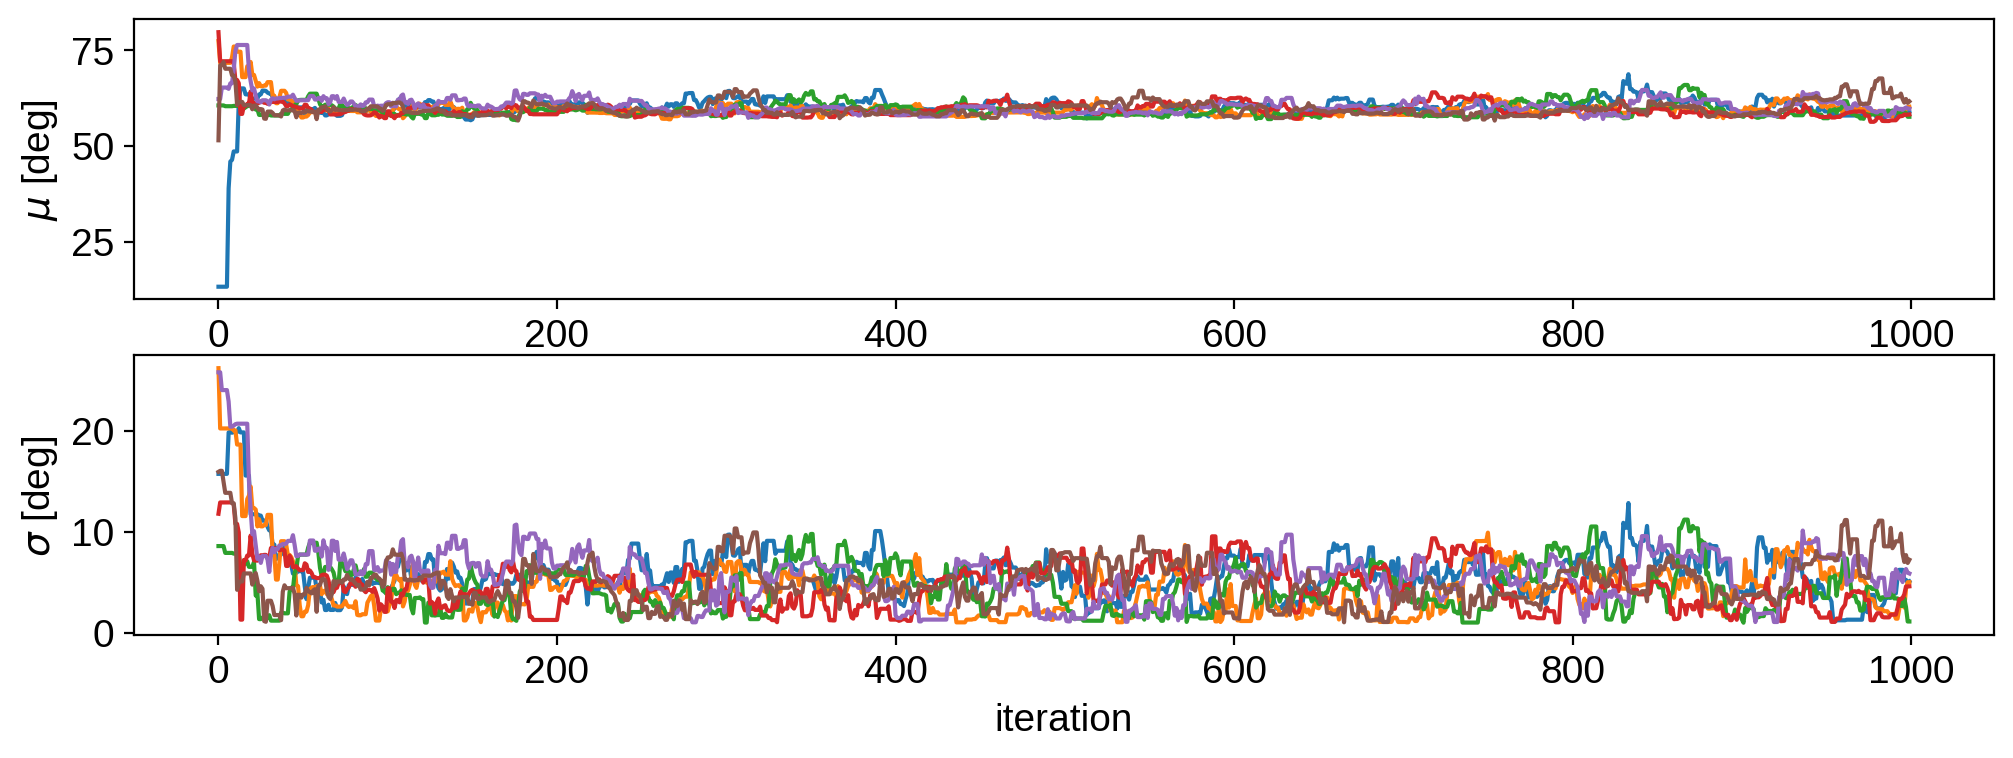

In [15]:
fig, ax = plt.subplots(2)
for k in range(nwalkers):
    ax[0].plot(chain1[k, :, 0])
    ax[1].plot(chain1[k, :, 1])
ax[0].set_ylabel(r"$\mu$ [deg]")
ax[1].set_ylabel(r"$\sigma$ [deg]")
ax[1].set_xlabel("iteration")
plt.show()

This has *definitely* not converged, but it's good enough for our toy example. Let's remove the first 100 samples as our burn-in and plot the joint posterior:

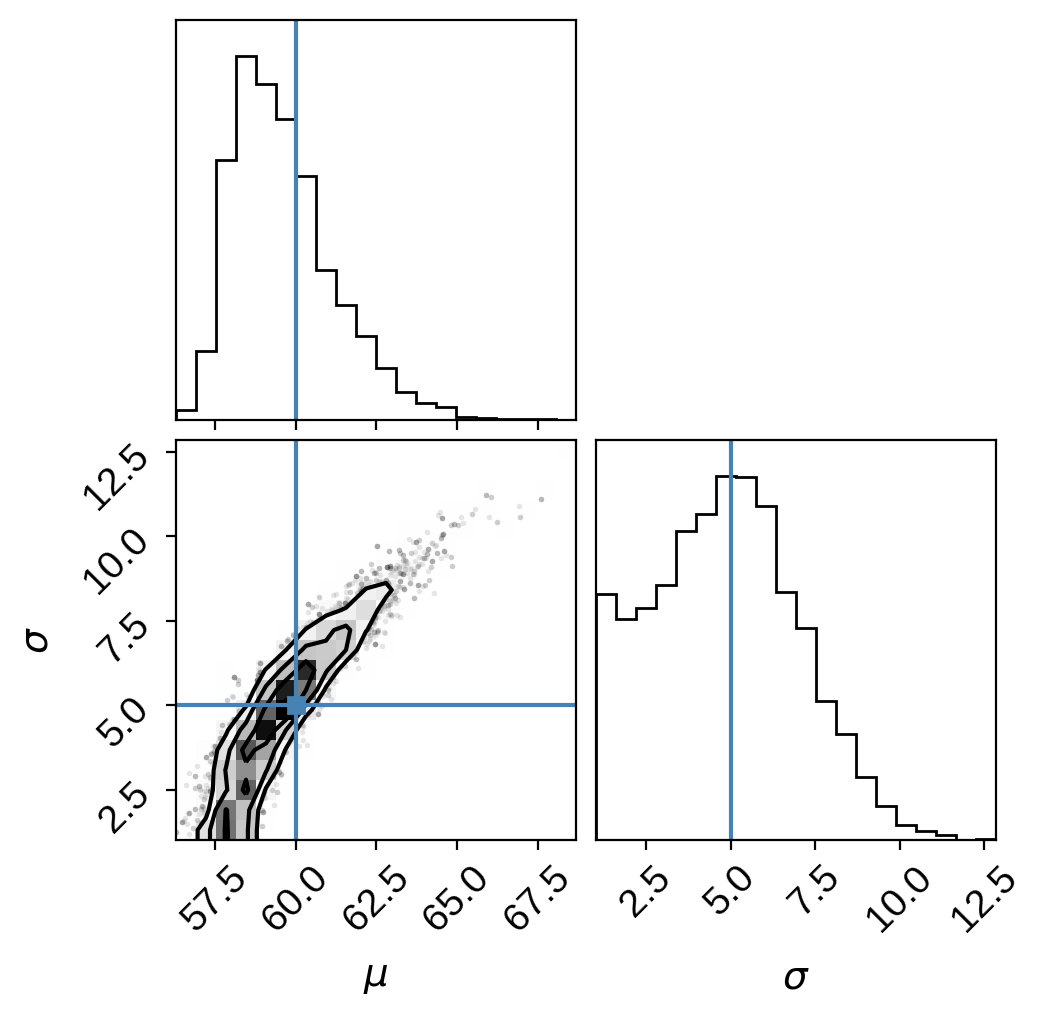

In [16]:
corner(chain1[:, 100:, :].reshape(-1, 2), truths=truths, labels=["$\mu$", "$\sigma$"])
plt.show()

Not bad! The true values are indicated in blue. We correctly infer the presence of high-latitude spots! Note, however, the degeneracy here. It's difficult to rule out polar spots with high variance! We discuss this at length in the paper. Pay attention to the curvature of the degeneracy, which gets worse for higher latitude spots. In some cases, this might be a very hard posterior to sample using MCMC!

### Sampling in `a`, `b`

As we mentioned above, it's preferable to sample in the dimensionless parameters `a` and `b`, which are just a (nonlinear) transformation of `mu` and `sigma` onto the unit square. There is a one-to-one correspondence between the two sets of quantities. Converting between them can be done via the utility functions

```python
mu, sigma = starry_process.beta2gauss(a, b)
```

and

```python
a, b = starry_process.gauss2beta(mu, sigma)
```

Let's compile our likelihood function to take `a` and `b` as input:

In [17]:
a_tensor = tt.dscalar()
b_tensor = tt.dscalar()
sp = StarryProcess(a=a_tensor, b=b_tensor)
log_likelihood2 = theano.function(
    [a_tensor, b_tensor],
    sp.log_likelihood(t, f, ferr ** 2) + sp.log_jac(),
)

Note that we added an extra term in the computation of the likelihood: `sp.log_jac()`. This is the log of the absolute value of the determinant of the Jacobian of the transformation (ugh!), which corrects for the (very wonky) implicit prior introduced by our reparametrization. By adding this term, we can place a uniform prior on `a` and `b` in `[0, 1]` and effectively obtain a uniform prior on `mu` and `sigma` when we transform our posterior constraints below.

Here's our log probability function, with the trivial prior on `a` and `b`:

In [18]:
def log_prob2(x):
    a, b = x
    if (a < 0) or (a > 1):
        return -np.inf
    elif (b < 0) or (b > 1):
        return -np.inf
    return log_likelihood2(a, b)


ndim, nwalkers = 2, 6
p0 = np.random.uniform(0, 1, size=(nwalkers, 2))

Let's run the sampler as before:

In [19]:
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_prob2)
_ = sampler2.run_mcmc(p0, 1000, progress=True)
chain2_ab = np.array(sampler2.chain)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<03:11,  5.21it/s]

  0%|          | 2/1000 [00:00<03:16,  5.07it/s]

  0%|          | 3/1000 [00:00<03:36,  4.61it/s]

  0%|          | 4/1000 [00:00<04:04,  4.07it/s]

  0%|          | 5/1000 [00:01<04:03,  4.09it/s]

  1%|          | 6/1000 [00:01<04:17,  3.86it/s]

  1%|          | 7/1000 [00:01<04:25,  3.74it/s]

  1%|          | 8/1000 [00:02<04:31,  3.65it/s]

  1%|          | 9/1000 [00:02<04:38,  3.56it/s]

  1%|          | 10/1000 [00:02<04:40,  3.53it/s]

  1%|          | 11/1000 [00:02<04:41,  3.51it/s]

  1%|          | 12/1000 [00:03<04:42,  3.49it/s]

  1%|▏         | 13/1000 [00:03<04:27,  3.68it/s]

  1%|▏         | 14/1000 [00:03<04:16,  3.84it/s]

  2%|▏         | 15/1000 [00:03<04:23,  3.73it/s]

  2%|▏         | 16/1000 [00:04<04:30,  3.64it/s]

  2%|▏         | 17/1000 [00:04<04:22,  3.74it/s]

  2%|▏         | 18/1000 [00:04<04:29,  3.65it/s]

  2%|▏         | 19/1000 [00:05<04:33,  3.59it/s]

  2%|▏         | 20/1000 [00:05<04:34,  3.57it/s]

  2%|▏         | 21/1000 [00:05<04:21,  3.74it/s]

  2%|▏         | 22/1000 [00:05<04:28,  3.65it/s]

  2%|▏         | 23/1000 [00:06<04:31,  3.60it/s]

  2%|▏         | 24/1000 [00:06<04:35,  3.55it/s]

  2%|▎         | 25/1000 [00:06<04:35,  3.54it/s]

  3%|▎         | 26/1000 [00:07<04:36,  3.53it/s]

  3%|▎         | 27/1000 [00:07<04:37,  3.51it/s]

  3%|▎         | 28/1000 [00:07<04:23,  3.69it/s]

  3%|▎         | 29/1000 [00:07<03:59,  4.06it/s]

  3%|▎         | 30/1000 [00:07<03:57,  4.08it/s]

  3%|▎         | 31/1000 [00:08<04:09,  3.89it/s]

  3%|▎         | 32/1000 [00:08<04:03,  3.98it/s]

  3%|▎         | 33/1000 [00:08<04:11,  3.84it/s]

  3%|▎         | 34/1000 [00:09<04:05,  3.93it/s]

  4%|▎         | 35/1000 [00:09<04:02,  3.98it/s]

  4%|▎         | 36/1000 [00:09<03:58,  4.04it/s]

  4%|▎         | 37/1000 [00:09<03:56,  4.08it/s]

  4%|▍         | 38/1000 [00:10<04:07,  3.88it/s]

  4%|▍         | 39/1000 [00:10<04:01,  3.99it/s]

  4%|▍         | 40/1000 [00:10<04:00,  4.00it/s]

  4%|▍         | 41/1000 [00:10<03:57,  4.04it/s]

  4%|▍         | 42/1000 [00:10<03:41,  4.33it/s]

  4%|▍         | 43/1000 [00:11<03:44,  4.27it/s]

  4%|▍         | 44/1000 [00:11<03:48,  4.18it/s]

  4%|▍         | 45/1000 [00:11<03:50,  4.14it/s]

  5%|▍         | 46/1000 [00:11<04:05,  3.88it/s]

  5%|▍         | 47/1000 [00:12<04:15,  3.73it/s]

  5%|▍         | 48/1000 [00:12<04:21,  3.64it/s]

  5%|▍         | 49/1000 [00:12<04:27,  3.56it/s]

  5%|▌         | 50/1000 [00:13<04:28,  3.54it/s]

  5%|▌         | 51/1000 [00:13<04:30,  3.51it/s]

  5%|▌         | 52/1000 [00:13<04:30,  3.50it/s]

  5%|▌         | 53/1000 [00:14<04:31,  3.48it/s]

  5%|▌         | 54/1000 [00:14<04:32,  3.47it/s]

  6%|▌         | 55/1000 [00:14<04:33,  3.46it/s]

  6%|▌         | 56/1000 [00:14<04:20,  3.63it/s]

  6%|▌         | 57/1000 [00:15<04:24,  3.57it/s]

  6%|▌         | 58/1000 [00:15<04:26,  3.53it/s]

  6%|▌         | 59/1000 [00:15<04:26,  3.53it/s]

  6%|▌         | 60/1000 [00:15<04:02,  3.88it/s]

  6%|▌         | 61/1000 [00:16<03:57,  3.96it/s]

  6%|▌         | 62/1000 [00:16<03:56,  3.97it/s]

  6%|▋         | 63/1000 [00:16<04:06,  3.81it/s]

  6%|▋         | 64/1000 [00:16<04:00,  3.89it/s]

  6%|▋         | 65/1000 [00:17<04:08,  3.76it/s]

  7%|▋         | 66/1000 [00:17<03:47,  4.10it/s]

  7%|▋         | 67/1000 [00:17<03:46,  4.13it/s]

  7%|▋         | 68/1000 [00:17<03:59,  3.89it/s]

  7%|▋         | 69/1000 [00:18<03:55,  3.96it/s]

  7%|▋         | 70/1000 [00:18<04:04,  3.80it/s]

  7%|▋         | 71/1000 [00:18<03:57,  3.92it/s]

  7%|▋         | 72/1000 [00:18<04:05,  3.78it/s]

  7%|▋         | 73/1000 [00:19<03:57,  3.90it/s]

  7%|▋         | 74/1000 [00:19<03:40,  4.21it/s]

  8%|▊         | 75/1000 [00:19<03:40,  4.19it/s]

  8%|▊         | 76/1000 [00:19<03:54,  3.94it/s]

  8%|▊         | 77/1000 [00:20<04:02,  3.80it/s]

  8%|▊         | 78/1000 [00:20<03:55,  3.91it/s]

  8%|▊         | 79/1000 [00:20<03:51,  3.98it/s]

  8%|▊         | 80/1000 [00:21<04:00,  3.82it/s]

  8%|▊         | 81/1000 [00:21<04:07,  3.71it/s]

  8%|▊         | 82/1000 [00:21<04:12,  3.63it/s]

  8%|▊         | 83/1000 [00:21<04:14,  3.60it/s]

  8%|▊         | 84/1000 [00:22<04:04,  3.75it/s]

  8%|▊         | 85/1000 [00:22<04:12,  3.62it/s]

  9%|▊         | 86/1000 [00:22<04:15,  3.58it/s]

  9%|▊         | 87/1000 [00:22<04:05,  3.72it/s]

  9%|▉         | 88/1000 [00:23<04:09,  3.65it/s]

  9%|▉         | 89/1000 [00:23<03:59,  3.80it/s]

  9%|▉         | 90/1000 [00:23<03:52,  3.92it/s]

  9%|▉         | 91/1000 [00:23<03:48,  3.98it/s]

  9%|▉         | 92/1000 [00:24<03:56,  3.83it/s]

  9%|▉         | 93/1000 [00:24<04:02,  3.74it/s]

  9%|▉         | 94/1000 [00:24<03:42,  4.07it/s]

 10%|▉         | 95/1000 [00:24<03:54,  3.86it/s]

 10%|▉         | 96/1000 [00:25<04:00,  3.76it/s]

 10%|▉         | 97/1000 [00:25<03:27,  4.35it/s]

 10%|▉         | 98/1000 [00:25<03:29,  4.30it/s]

 10%|▉         | 99/1000 [00:25<03:31,  4.25it/s]

 10%|█         | 100/1000 [00:26<03:33,  4.22it/s]

 10%|█         | 101/1000 [00:26<03:42,  4.03it/s]

 10%|█         | 102/1000 [00:26<03:40,  4.07it/s]

 10%|█         | 103/1000 [00:26<03:39,  4.09it/s]

 10%|█         | 104/1000 [00:27<03:49,  3.90it/s]

 10%|█         | 105/1000 [00:27<03:58,  3.76it/s]

 11%|█         | 106/1000 [00:27<04:03,  3.67it/s]

 11%|█         | 107/1000 [00:27<03:54,  3.80it/s]

 11%|█         | 108/1000 [00:28<04:00,  3.71it/s]

 11%|█         | 109/1000 [00:28<04:05,  3.64it/s]

 11%|█         | 110/1000 [00:28<04:07,  3.59it/s]

 11%|█         | 111/1000 [00:29<04:11,  3.54it/s]

 11%|█         | 112/1000 [00:29<04:14,  3.49it/s]

 11%|█▏        | 113/1000 [00:29<04:14,  3.49it/s]

 11%|█▏        | 114/1000 [00:30<04:16,  3.46it/s]

 12%|█▏        | 115/1000 [00:30<04:15,  3.47it/s]

 12%|█▏        | 116/1000 [00:30<04:14,  3.47it/s]

 12%|█▏        | 117/1000 [00:30<04:14,  3.47it/s]

 12%|█▏        | 118/1000 [00:31<04:14,  3.47it/s]

 12%|█▏        | 119/1000 [00:31<04:14,  3.47it/s]

 12%|█▏        | 120/1000 [00:31<04:12,  3.48it/s]

 12%|█▏        | 121/1000 [00:32<04:12,  3.48it/s]

 12%|█▏        | 122/1000 [00:32<04:12,  3.48it/s]

 12%|█▏        | 123/1000 [00:32<04:13,  3.46it/s]

 12%|█▏        | 124/1000 [00:32<04:14,  3.44it/s]

 12%|█▎        | 125/1000 [00:33<04:13,  3.45it/s]

 13%|█▎        | 126/1000 [00:33<04:13,  3.45it/s]

 13%|█▎        | 127/1000 [00:33<04:11,  3.47it/s]

 13%|█▎        | 128/1000 [00:34<04:11,  3.46it/s]

 13%|█▎        | 129/1000 [00:34<04:10,  3.47it/s]

 13%|█▎        | 130/1000 [00:34<04:10,  3.47it/s]

 13%|█▎        | 131/1000 [00:34<04:12,  3.45it/s]

 13%|█▎        | 132/1000 [00:35<04:11,  3.45it/s]

 13%|█▎        | 133/1000 [00:35<03:57,  3.65it/s]

 13%|█▎        | 134/1000 [00:35<03:59,  3.62it/s]

 14%|█▎        | 135/1000 [00:36<04:02,  3.57it/s]

 14%|█▎        | 136/1000 [00:36<04:04,  3.53it/s]

 14%|█▎        | 137/1000 [00:36<04:05,  3.51it/s]

 14%|█▍        | 138/1000 [00:36<04:06,  3.50it/s]

 14%|█▍        | 139/1000 [00:37<04:06,  3.49it/s]

 14%|█▍        | 140/1000 [00:37<04:06,  3.49it/s]

 14%|█▍        | 141/1000 [00:37<04:07,  3.47it/s]

 14%|█▍        | 142/1000 [00:38<04:08,  3.45it/s]

 14%|█▍        | 143/1000 [00:38<04:08,  3.45it/s]

 14%|█▍        | 144/1000 [00:38<04:06,  3.47it/s]

 14%|█▍        | 145/1000 [00:38<04:07,  3.45it/s]

 15%|█▍        | 146/1000 [00:39<04:06,  3.47it/s]

 15%|█▍        | 147/1000 [00:39<04:05,  3.48it/s]

 15%|█▍        | 148/1000 [00:39<04:04,  3.48it/s]

 15%|█▍        | 149/1000 [00:40<03:52,  3.65it/s]

 15%|█▌        | 150/1000 [00:40<03:43,  3.80it/s]

 15%|█▌        | 151/1000 [00:40<03:51,  3.67it/s]

 15%|█▌        | 152/1000 [00:40<03:44,  3.78it/s]

 15%|█▌        | 153/1000 [00:41<03:40,  3.84it/s]

 15%|█▌        | 154/1000 [00:41<03:35,  3.92it/s]

 16%|█▌        | 155/1000 [00:41<03:46,  3.73it/s]

 16%|█▌        | 156/1000 [00:41<03:40,  3.83it/s]

 16%|█▌        | 157/1000 [00:42<03:34,  3.93it/s]

 16%|█▌        | 158/1000 [00:42<03:31,  3.99it/s]

 16%|█▌        | 159/1000 [00:42<03:41,  3.80it/s]

 16%|█▌        | 160/1000 [00:42<03:47,  3.69it/s]

 16%|█▌        | 161/1000 [00:43<03:51,  3.63it/s]

 16%|█▌        | 162/1000 [00:43<03:53,  3.59it/s]

 16%|█▋        | 163/1000 [00:43<03:55,  3.55it/s]

 16%|█▋        | 164/1000 [00:44<03:56,  3.53it/s]

 16%|█▋        | 165/1000 [00:44<03:57,  3.51it/s]

 17%|█▋        | 166/1000 [00:44<03:58,  3.50it/s]

 17%|█▋        | 167/1000 [00:44<03:58,  3.49it/s]

 17%|█▋        | 168/1000 [00:45<03:58,  3.49it/s]

 17%|█▋        | 169/1000 [00:45<03:57,  3.50it/s]

 17%|█▋        | 170/1000 [00:45<03:57,  3.50it/s]

 17%|█▋        | 171/1000 [00:46<03:58,  3.47it/s]

 17%|█▋        | 172/1000 [00:46<03:58,  3.47it/s]

 17%|█▋        | 173/1000 [00:46<03:59,  3.45it/s]

 17%|█▋        | 174/1000 [00:46<04:00,  3.44it/s]

 18%|█▊        | 175/1000 [00:47<04:00,  3.43it/s]

 18%|█▊        | 176/1000 [00:47<03:58,  3.46it/s]

 18%|█▊        | 177/1000 [00:47<04:04,  3.37it/s]

 18%|█▊        | 178/1000 [00:48<04:01,  3.40it/s]

 18%|█▊        | 179/1000 [00:48<03:59,  3.43it/s]

 18%|█▊        | 180/1000 [00:48<03:56,  3.46it/s]

 18%|█▊        | 181/1000 [00:48<03:57,  3.45it/s]

 18%|█▊        | 182/1000 [00:49<03:55,  3.47it/s]

 18%|█▊        | 183/1000 [00:49<03:55,  3.47it/s]

 18%|█▊        | 184/1000 [00:49<03:54,  3.47it/s]

 18%|█▊        | 185/1000 [00:50<03:55,  3.46it/s]

 19%|█▊        | 186/1000 [00:50<03:54,  3.48it/s]

 19%|█▊        | 187/1000 [00:50<03:54,  3.47it/s]

 19%|█▉        | 188/1000 [00:50<03:54,  3.46it/s]

 19%|█▉        | 189/1000 [00:51<03:54,  3.46it/s]

 19%|█▉        | 190/1000 [00:51<03:54,  3.46it/s]

 19%|█▉        | 191/1000 [00:51<03:54,  3.46it/s]

 19%|█▉        | 192/1000 [00:52<03:54,  3.44it/s]

 19%|█▉        | 193/1000 [00:52<03:53,  3.45it/s]

 19%|█▉        | 194/1000 [00:52<03:53,  3.45it/s]

 20%|█▉        | 195/1000 [00:52<03:42,  3.62it/s]

 20%|█▉        | 196/1000 [00:53<03:45,  3.57it/s]

 20%|█▉        | 197/1000 [00:53<03:36,  3.71it/s]

 20%|█▉        | 198/1000 [00:53<03:28,  3.84it/s]

 20%|█▉        | 199/1000 [00:53<03:23,  3.94it/s]

 20%|██        | 200/1000 [00:54<03:30,  3.79it/s]

 20%|██        | 201/1000 [00:54<03:25,  3.89it/s]

 20%|██        | 202/1000 [00:54<03:20,  3.97it/s]

 20%|██        | 203/1000 [00:55<03:19,  4.00it/s]

 20%|██        | 204/1000 [00:55<03:28,  3.82it/s]

 20%|██        | 205/1000 [00:55<03:23,  3.91it/s]

 21%|██        | 206/1000 [00:55<03:29,  3.78it/s]

 21%|██        | 207/1000 [00:56<03:36,  3.67it/s]

 21%|██        | 208/1000 [00:56<03:28,  3.80it/s]

 21%|██        | 209/1000 [00:56<03:35,  3.67it/s]

 21%|██        | 210/1000 [00:56<03:39,  3.61it/s]

 21%|██        | 211/1000 [00:57<03:18,  3.97it/s]

 21%|██        | 212/1000 [00:57<03:14,  4.04it/s]

 21%|██▏       | 213/1000 [00:57<03:23,  3.87it/s]

 21%|██▏       | 214/1000 [00:57<03:30,  3.73it/s]

 22%|██▏       | 215/1000 [00:58<03:34,  3.65it/s]

 22%|██▏       | 216/1000 [00:58<03:26,  3.79it/s]

 22%|██▏       | 217/1000 [00:58<03:34,  3.65it/s]

 22%|██▏       | 218/1000 [00:59<03:37,  3.59it/s]

 22%|██▏       | 219/1000 [00:59<03:38,  3.58it/s]

 22%|██▏       | 220/1000 [00:59<03:40,  3.54it/s]

 22%|██▏       | 221/1000 [00:59<03:42,  3.51it/s]

 22%|██▏       | 222/1000 [01:00<03:31,  3.68it/s]

 22%|██▏       | 223/1000 [01:00<03:35,  3.61it/s]

 22%|██▏       | 224/1000 [01:00<03:37,  3.57it/s]

 22%|██▎       | 225/1000 [01:01<03:38,  3.54it/s]

 23%|██▎       | 226/1000 [01:01<03:39,  3.52it/s]

 23%|██▎       | 227/1000 [01:01<03:39,  3.52it/s]

 23%|██▎       | 228/1000 [01:01<03:40,  3.51it/s]

 23%|██▎       | 229/1000 [01:02<03:40,  3.50it/s]

 23%|██▎       | 230/1000 [01:02<03:30,  3.66it/s]

 23%|██▎       | 231/1000 [01:02<03:32,  3.62it/s]

 23%|██▎       | 232/1000 [01:02<03:35,  3.57it/s]

 23%|██▎       | 233/1000 [01:03<03:36,  3.55it/s]

 23%|██▎       | 234/1000 [01:03<03:37,  3.52it/s]

 24%|██▎       | 235/1000 [01:03<03:38,  3.51it/s]

 24%|██▎       | 236/1000 [01:04<03:38,  3.49it/s]

 24%|██▎       | 237/1000 [01:04<03:27,  3.68it/s]

 24%|██▍       | 238/1000 [01:04<03:31,  3.61it/s]

 24%|██▍       | 239/1000 [01:04<03:23,  3.75it/s]

 24%|██▍       | 240/1000 [01:05<03:27,  3.67it/s]

 24%|██▍       | 241/1000 [01:05<03:29,  3.62it/s]

 24%|██▍       | 242/1000 [01:05<03:30,  3.60it/s]

 24%|██▍       | 243/1000 [01:06<03:33,  3.55it/s]

 24%|██▍       | 244/1000 [01:06<03:34,  3.53it/s]

 24%|██▍       | 245/1000 [01:06<03:35,  3.51it/s]

 25%|██▍       | 246/1000 [01:06<03:35,  3.50it/s]

 25%|██▍       | 247/1000 [01:07<03:34,  3.51it/s]

 25%|██▍       | 248/1000 [01:07<03:33,  3.52it/s]

 25%|██▍       | 249/1000 [01:07<03:33,  3.52it/s]

 25%|██▌       | 250/1000 [01:08<03:34,  3.50it/s]

 25%|██▌       | 251/1000 [01:08<03:33,  3.51it/s]

 25%|██▌       | 252/1000 [01:08<03:32,  3.52it/s]

 25%|██▌       | 253/1000 [01:08<03:32,  3.52it/s]

 25%|██▌       | 254/1000 [01:09<03:22,  3.69it/s]

 26%|██▌       | 255/1000 [01:09<03:25,  3.62it/s]

 26%|██▌       | 256/1000 [01:09<03:32,  3.50it/s]

 26%|██▌       | 257/1000 [01:10<03:33,  3.49it/s]

 26%|██▌       | 258/1000 [01:10<03:31,  3.50it/s]

 26%|██▌       | 259/1000 [01:10<03:31,  3.50it/s]

 26%|██▌       | 260/1000 [01:10<03:33,  3.46it/s]

 26%|██▌       | 261/1000 [01:11<03:34,  3.45it/s]

 26%|██▌       | 262/1000 [01:11<03:33,  3.45it/s]

 26%|██▋       | 263/1000 [01:11<03:22,  3.64it/s]

 26%|██▋       | 264/1000 [01:11<03:14,  3.78it/s]

 26%|██▋       | 265/1000 [01:12<03:09,  3.87it/s]

 27%|██▋       | 266/1000 [01:12<03:15,  3.75it/s]

 27%|██▋       | 267/1000 [01:12<03:10,  3.85it/s]

 27%|██▋       | 268/1000 [01:13<03:16,  3.72it/s]

 27%|██▋       | 269/1000 [01:13<03:20,  3.65it/s]

 27%|██▋       | 270/1000 [01:13<03:11,  3.81it/s]

 27%|██▋       | 271/1000 [01:13<03:05,  3.92it/s]

 27%|██▋       | 272/1000 [01:14<03:12,  3.78it/s]

 27%|██▋       | 273/1000 [01:14<03:07,  3.88it/s]

 27%|██▋       | 274/1000 [01:14<03:13,  3.76it/s]

 28%|██▊       | 275/1000 [01:14<03:17,  3.67it/s]

 28%|██▊       | 276/1000 [01:15<03:10,  3.81it/s]

 28%|██▊       | 277/1000 [01:15<03:15,  3.70it/s]

 28%|██▊       | 278/1000 [01:15<02:47,  4.31it/s]

 28%|██▊       | 279/1000 [01:15<02:48,  4.28it/s]

 28%|██▊       | 280/1000 [01:15<02:39,  4.52it/s]

 28%|██▊       | 281/1000 [01:16<02:42,  4.41it/s]

 28%|██▊       | 282/1000 [01:16<02:46,  4.33it/s]

 28%|██▊       | 283/1000 [01:16<02:47,  4.28it/s]

 28%|██▊       | 284/1000 [01:16<02:51,  4.17it/s]

 28%|██▊       | 285/1000 [01:17<03:00,  3.96it/s]

 29%|██▊       | 286/1000 [01:17<02:56,  4.04it/s]

 29%|██▊       | 287/1000 [01:17<03:05,  3.85it/s]

 29%|██▉       | 288/1000 [01:18<03:10,  3.73it/s]

 29%|██▉       | 289/1000 [01:18<03:03,  3.87it/s]

 29%|██▉       | 290/1000 [01:18<03:09,  3.75it/s]

 29%|██▉       | 291/1000 [01:18<03:12,  3.68it/s]

 29%|██▉       | 292/1000 [01:19<03:15,  3.63it/s]

 29%|██▉       | 293/1000 [01:19<03:16,  3.59it/s]

 29%|██▉       | 294/1000 [01:19<03:18,  3.56it/s]

 30%|██▉       | 295/1000 [01:19<03:19,  3.54it/s]

 30%|██▉       | 296/1000 [01:20<03:19,  3.53it/s]

 30%|██▉       | 297/1000 [01:20<03:18,  3.54it/s]

 30%|██▉       | 298/1000 [01:20<03:19,  3.52it/s]

 30%|██▉       | 299/1000 [01:21<03:19,  3.51it/s]

 30%|███       | 300/1000 [01:21<03:19,  3.50it/s]

 30%|███       | 301/1000 [01:21<03:19,  3.50it/s]

 30%|███       | 302/1000 [01:21<03:19,  3.50it/s]

 30%|███       | 303/1000 [01:22<03:19,  3.49it/s]

 30%|███       | 304/1000 [01:22<03:19,  3.49it/s]

 30%|███       | 305/1000 [01:22<03:20,  3.46it/s]

 31%|███       | 306/1000 [01:23<03:20,  3.47it/s]

 31%|███       | 307/1000 [01:23<03:19,  3.47it/s]

 31%|███       | 308/1000 [01:23<03:18,  3.49it/s]

 31%|███       | 309/1000 [01:24<03:18,  3.48it/s]

 31%|███       | 310/1000 [01:24<03:17,  3.49it/s]

 31%|███       | 311/1000 [01:24<03:16,  3.50it/s]

 31%|███       | 312/1000 [01:24<03:16,  3.50it/s]

 31%|███▏      | 313/1000 [01:25<03:06,  3.68it/s]

 31%|███▏      | 314/1000 [01:25<02:49,  4.05it/s]

 32%|███▏      | 315/1000 [01:25<02:57,  3.87it/s]

 32%|███▏      | 316/1000 [01:25<02:43,  4.19it/s]

 32%|███▏      | 317/1000 [01:26<02:43,  4.18it/s]

 32%|███▏      | 318/1000 [01:26<02:23,  4.74it/s]

 32%|███▏      | 319/1000 [01:26<02:33,  4.45it/s]

 32%|███▏      | 320/1000 [01:26<02:45,  4.11it/s]

 32%|███▏      | 321/1000 [01:26<02:54,  3.88it/s]

 32%|███▏      | 322/1000 [01:27<02:49,  3.99it/s]

 32%|███▏      | 323/1000 [01:27<02:56,  3.83it/s]

 32%|███▏      | 324/1000 [01:27<03:01,  3.72it/s]

 32%|███▎      | 325/1000 [01:28<03:05,  3.64it/s]

 33%|███▎      | 326/1000 [01:28<03:07,  3.60it/s]

 33%|███▎      | 327/1000 [01:28<03:08,  3.57it/s]

 33%|███▎      | 328/1000 [01:28<03:11,  3.50it/s]

 33%|███▎      | 329/1000 [01:29<03:11,  3.51it/s]

 33%|███▎      | 330/1000 [01:29<03:11,  3.50it/s]

 33%|███▎      | 331/1000 [01:29<03:12,  3.48it/s]

 33%|███▎      | 332/1000 [01:30<03:12,  3.46it/s]

 33%|███▎      | 333/1000 [01:30<03:12,  3.46it/s]

 33%|███▎      | 334/1000 [01:30<03:12,  3.46it/s]

 34%|███▎      | 335/1000 [01:30<03:02,  3.63it/s]

 34%|███▎      | 336/1000 [01:31<03:05,  3.59it/s]

 34%|███▎      | 337/1000 [01:31<03:06,  3.55it/s]

 34%|███▍      | 338/1000 [01:31<03:07,  3.52it/s]

 34%|███▍      | 339/1000 [01:32<03:08,  3.51it/s]

 34%|███▍      | 340/1000 [01:32<02:59,  3.68it/s]

 34%|███▍      | 341/1000 [01:32<03:02,  3.61it/s]

 34%|███▍      | 342/1000 [01:32<03:05,  3.55it/s]

 34%|███▍      | 343/1000 [01:33<03:06,  3.53it/s]

 34%|███▍      | 344/1000 [01:33<03:06,  3.51it/s]

 34%|███▍      | 345/1000 [01:33<03:06,  3.51it/s]

 35%|███▍      | 346/1000 [01:34<03:06,  3.50it/s]

 35%|███▍      | 347/1000 [01:34<03:06,  3.49it/s]

 35%|███▍      | 348/1000 [01:34<03:07,  3.48it/s]

 35%|███▍      | 349/1000 [01:34<03:08,  3.45it/s]

 35%|███▌      | 350/1000 [01:35<03:07,  3.47it/s]

 35%|███▌      | 351/1000 [01:35<03:06,  3.47it/s]

 35%|███▌      | 352/1000 [01:35<03:05,  3.49it/s]

 35%|███▌      | 353/1000 [01:36<03:05,  3.48it/s]

 35%|███▌      | 354/1000 [01:36<03:05,  3.48it/s]

 36%|███▌      | 355/1000 [01:36<03:05,  3.47it/s]

 36%|███▌      | 356/1000 [01:36<03:05,  3.47it/s]

 36%|███▌      | 357/1000 [01:37<03:05,  3.47it/s]

 36%|███▌      | 358/1000 [01:37<03:05,  3.46it/s]

 36%|███▌      | 359/1000 [01:37<03:06,  3.43it/s]

 36%|███▌      | 360/1000 [01:38<03:08,  3.40it/s]

 36%|███▌      | 361/1000 [01:38<03:08,  3.39it/s]

 36%|███▌      | 362/1000 [01:38<03:07,  3.40it/s]

 36%|███▋      | 363/1000 [01:39<03:07,  3.39it/s]

 36%|███▋      | 364/1000 [01:39<03:08,  3.38it/s]

 36%|███▋      | 365/1000 [01:39<03:07,  3.38it/s]

 37%|███▋      | 366/1000 [01:39<03:07,  3.38it/s]

 37%|███▋      | 367/1000 [01:40<03:06,  3.39it/s]

 37%|███▋      | 368/1000 [01:40<03:06,  3.39it/s]

 37%|███▋      | 369/1000 [01:40<03:06,  3.38it/s]

 37%|███▋      | 370/1000 [01:41<03:11,  3.30it/s]

 37%|███▋      | 371/1000 [01:41<03:09,  3.31it/s]

 37%|███▋      | 372/1000 [01:41<03:06,  3.36it/s]

 37%|███▋      | 373/1000 [01:41<03:04,  3.41it/s]

 37%|███▋      | 374/1000 [01:42<03:02,  3.43it/s]

 38%|███▊      | 375/1000 [01:42<03:01,  3.44it/s]

 38%|███▊      | 376/1000 [01:42<03:03,  3.41it/s]

 38%|███▊      | 377/1000 [01:43<03:02,  3.42it/s]

 38%|███▊      | 378/1000 [01:43<03:00,  3.44it/s]

 38%|███▊      | 379/1000 [01:43<03:01,  3.43it/s]

 38%|███▊      | 380/1000 [01:44<03:00,  3.44it/s]

 38%|███▊      | 381/1000 [01:44<03:00,  3.44it/s]

 38%|███▊      | 382/1000 [01:44<02:59,  3.45it/s]

 38%|███▊      | 383/1000 [01:44<02:59,  3.44it/s]

 38%|███▊      | 384/1000 [01:45<02:58,  3.45it/s]

 38%|███▊      | 385/1000 [01:45<02:58,  3.45it/s]

 39%|███▊      | 386/1000 [01:45<02:57,  3.45it/s]

 39%|███▊      | 387/1000 [01:46<02:57,  3.45it/s]

 39%|███▉      | 388/1000 [01:46<02:57,  3.44it/s]

 39%|███▉      | 389/1000 [01:46<02:57,  3.43it/s]

 39%|███▉      | 390/1000 [01:46<02:58,  3.42it/s]

 39%|███▉      | 391/1000 [01:47<02:59,  3.39it/s]

 39%|███▉      | 392/1000 [01:47<02:57,  3.42it/s]

 39%|███▉      | 393/1000 [01:47<02:56,  3.44it/s]

 39%|███▉      | 394/1000 [01:48<02:55,  3.44it/s]

 40%|███▉      | 395/1000 [01:48<02:54,  3.46it/s]

 40%|███▉      | 396/1000 [01:48<02:53,  3.48it/s]

 40%|███▉      | 397/1000 [01:48<02:52,  3.49it/s]

 40%|███▉      | 398/1000 [01:49<02:52,  3.49it/s]

 40%|███▉      | 399/1000 [01:49<02:53,  3.47it/s]

 40%|████      | 400/1000 [01:49<02:52,  3.47it/s]

 40%|████      | 401/1000 [01:50<02:52,  3.47it/s]

 40%|████      | 402/1000 [01:50<02:52,  3.46it/s]

 40%|████      | 403/1000 [01:50<02:52,  3.47it/s]

 40%|████      | 404/1000 [01:50<02:52,  3.46it/s]

 40%|████      | 405/1000 [01:51<02:51,  3.47it/s]

 41%|████      | 406/1000 [01:51<02:51,  3.47it/s]

 41%|████      | 407/1000 [01:51<02:50,  3.48it/s]

 41%|████      | 408/1000 [01:52<02:49,  3.49it/s]

 41%|████      | 409/1000 [01:52<02:49,  3.48it/s]

 41%|████      | 410/1000 [01:52<02:49,  3.48it/s]

 41%|████      | 411/1000 [01:52<02:49,  3.47it/s]

 41%|████      | 412/1000 [01:53<02:50,  3.45it/s]

 41%|████▏     | 413/1000 [01:53<02:51,  3.43it/s]

 41%|████▏     | 414/1000 [01:53<02:51,  3.42it/s]

 42%|████▏     | 415/1000 [01:54<02:50,  3.44it/s]

 42%|████▏     | 416/1000 [01:54<02:49,  3.45it/s]

 42%|████▏     | 417/1000 [01:54<02:48,  3.47it/s]

 42%|████▏     | 418/1000 [01:54<02:48,  3.46it/s]

 42%|████▏     | 419/1000 [01:55<02:47,  3.48it/s]

 42%|████▏     | 420/1000 [01:55<02:47,  3.47it/s]

 42%|████▏     | 421/1000 [01:55<02:47,  3.46it/s]

 42%|████▏     | 422/1000 [01:56<02:47,  3.45it/s]

 42%|████▏     | 423/1000 [01:56<02:47,  3.45it/s]

 42%|████▏     | 424/1000 [01:56<02:46,  3.45it/s]

 42%|████▎     | 425/1000 [01:57<02:46,  3.45it/s]

 43%|████▎     | 426/1000 [01:57<02:45,  3.47it/s]

 43%|████▎     | 427/1000 [01:57<02:44,  3.49it/s]

 43%|████▎     | 428/1000 [01:57<02:44,  3.48it/s]

 43%|████▎     | 429/1000 [01:58<02:44,  3.48it/s]

 43%|████▎     | 430/1000 [01:58<02:44,  3.47it/s]

 43%|████▎     | 431/1000 [01:58<02:43,  3.47it/s]

 43%|████▎     | 432/1000 [01:59<02:45,  3.43it/s]

 43%|████▎     | 433/1000 [01:59<02:45,  3.42it/s]

 43%|████▎     | 434/1000 [01:59<02:45,  3.42it/s]

 44%|████▎     | 435/1000 [01:59<02:44,  3.42it/s]

 44%|████▎     | 436/1000 [02:00<02:44,  3.42it/s]

 44%|████▎     | 437/1000 [02:00<02:44,  3.43it/s]

 44%|████▍     | 438/1000 [02:00<02:44,  3.42it/s]

 44%|████▍     | 439/1000 [02:01<02:44,  3.42it/s]

 44%|████▍     | 440/1000 [02:01<02:43,  3.43it/s]

 44%|████▍     | 441/1000 [02:01<02:42,  3.43it/s]

 44%|████▍     | 442/1000 [02:01<02:42,  3.44it/s]

 44%|████▍     | 443/1000 [02:02<02:41,  3.44it/s]

 44%|████▍     | 444/1000 [02:02<02:41,  3.44it/s]

 44%|████▍     | 445/1000 [02:02<02:40,  3.46it/s]

 45%|████▍     | 446/1000 [02:03<02:40,  3.46it/s]

 45%|████▍     | 447/1000 [02:03<02:39,  3.46it/s]

 45%|████▍     | 448/1000 [02:03<02:39,  3.47it/s]

 45%|████▍     | 449/1000 [02:03<02:39,  3.46it/s]

 45%|████▌     | 450/1000 [02:04<02:38,  3.47it/s]

 45%|████▌     | 451/1000 [02:04<02:38,  3.47it/s]

 45%|████▌     | 452/1000 [02:04<02:38,  3.46it/s]

 45%|████▌     | 453/1000 [02:05<02:39,  3.43it/s]

 45%|████▌     | 454/1000 [02:05<02:38,  3.45it/s]

 46%|████▌     | 455/1000 [02:05<02:37,  3.46it/s]

 46%|████▌     | 456/1000 [02:06<02:37,  3.46it/s]

 46%|████▌     | 457/1000 [02:06<02:36,  3.46it/s]

 46%|████▌     | 458/1000 [02:06<02:36,  3.46it/s]

 46%|████▌     | 459/1000 [02:06<02:36,  3.45it/s]

 46%|████▌     | 460/1000 [02:07<02:36,  3.46it/s]

 46%|████▌     | 461/1000 [02:07<02:35,  3.46it/s]

 46%|████▌     | 462/1000 [02:07<02:35,  3.46it/s]

 46%|████▋     | 463/1000 [02:08<02:35,  3.44it/s]

 46%|████▋     | 464/1000 [02:08<02:35,  3.45it/s]

 46%|████▋     | 465/1000 [02:08<02:34,  3.46it/s]

 47%|████▋     | 466/1000 [02:08<02:33,  3.47it/s]

 47%|████▋     | 467/1000 [02:09<02:34,  3.45it/s]

 47%|████▋     | 468/1000 [02:09<02:34,  3.44it/s]

 47%|████▋     | 469/1000 [02:09<02:33,  3.45it/s]

 47%|████▋     | 470/1000 [02:10<02:33,  3.46it/s]

 47%|████▋     | 471/1000 [02:10<02:32,  3.47it/s]

 47%|████▋     | 472/1000 [02:10<02:31,  3.48it/s]

 47%|████▋     | 473/1000 [02:10<02:31,  3.48it/s]

 47%|████▋     | 474/1000 [02:11<02:33,  3.44it/s]

 48%|████▊     | 475/1000 [02:11<02:33,  3.41it/s]

 48%|████▊     | 476/1000 [02:11<02:33,  3.42it/s]

 48%|████▊     | 477/1000 [02:12<02:32,  3.43it/s]

 48%|████▊     | 478/1000 [02:12<02:32,  3.43it/s]

 48%|████▊     | 479/1000 [02:12<02:31,  3.44it/s]

 48%|████▊     | 480/1000 [02:12<02:31,  3.44it/s]

 48%|████▊     | 481/1000 [02:13<02:29,  3.46it/s]

 48%|████▊     | 482/1000 [02:13<02:29,  3.47it/s]

 48%|████▊     | 483/1000 [02:13<02:28,  3.47it/s]

 48%|████▊     | 484/1000 [02:14<02:28,  3.47it/s]

 48%|████▊     | 485/1000 [02:14<02:29,  3.45it/s]

 49%|████▊     | 486/1000 [02:14<02:29,  3.44it/s]

 49%|████▊     | 487/1000 [02:14<02:28,  3.45it/s]

 49%|████▉     | 488/1000 [02:15<02:27,  3.46it/s]

 49%|████▉     | 489/1000 [02:15<02:27,  3.46it/s]

 49%|████▉     | 490/1000 [02:15<02:27,  3.46it/s]

 49%|████▉     | 491/1000 [02:16<02:27,  3.45it/s]

 49%|████▉     | 492/1000 [02:16<02:26,  3.46it/s]

 49%|████▉     | 493/1000 [02:16<02:26,  3.47it/s]

 49%|████▉     | 494/1000 [02:17<02:26,  3.45it/s]

 50%|████▉     | 495/1000 [02:17<02:27,  3.42it/s]

 50%|████▉     | 496/1000 [02:17<02:26,  3.44it/s]

 50%|████▉     | 497/1000 [02:17<02:26,  3.44it/s]

 50%|████▉     | 498/1000 [02:18<02:25,  3.44it/s]

 50%|████▉     | 499/1000 [02:18<02:25,  3.45it/s]

 50%|█████     | 500/1000 [02:18<02:24,  3.46it/s]

 50%|█████     | 501/1000 [02:19<02:24,  3.46it/s]

 50%|█████     | 502/1000 [02:19<02:23,  3.47it/s]

 50%|█████     | 503/1000 [02:19<02:23,  3.47it/s]

 50%|█████     | 504/1000 [02:19<02:22,  3.47it/s]

 50%|█████     | 505/1000 [02:20<02:22,  3.48it/s]

 51%|█████     | 506/1000 [02:20<02:21,  3.48it/s]

 51%|█████     | 507/1000 [02:20<02:21,  3.48it/s]

 51%|█████     | 508/1000 [02:21<02:21,  3.47it/s]

 51%|█████     | 509/1000 [02:21<02:21,  3.47it/s]

 51%|█████     | 510/1000 [02:21<02:21,  3.46it/s]

 51%|█████     | 511/1000 [02:21<02:21,  3.46it/s]

 51%|█████     | 512/1000 [02:22<02:21,  3.46it/s]

 51%|█████▏    | 513/1000 [02:22<02:20,  3.47it/s]

 51%|█████▏    | 514/1000 [02:22<02:19,  3.48it/s]

 52%|█████▏    | 515/1000 [02:23<02:19,  3.47it/s]

 52%|█████▏    | 516/1000 [02:23<02:20,  3.45it/s]

 52%|█████▏    | 517/1000 [02:23<02:19,  3.47it/s]

 52%|█████▏    | 518/1000 [02:23<02:19,  3.47it/s]

 52%|█████▏    | 519/1000 [02:24<02:18,  3.48it/s]

 52%|█████▏    | 520/1000 [02:24<02:17,  3.49it/s]

 52%|█████▏    | 521/1000 [02:24<02:17,  3.48it/s]

 52%|█████▏    | 522/1000 [02:25<02:17,  3.46it/s]

 52%|█████▏    | 523/1000 [02:25<02:17,  3.48it/s]

 52%|█████▏    | 524/1000 [02:25<02:16,  3.48it/s]

 52%|█████▎    | 525/1000 [02:25<02:16,  3.48it/s]

 53%|█████▎    | 526/1000 [02:26<02:20,  3.38it/s]

 53%|█████▎    | 527/1000 [02:26<02:19,  3.40it/s]

 53%|█████▎    | 528/1000 [02:26<02:18,  3.42it/s]

 53%|█████▎    | 529/1000 [02:27<02:17,  3.43it/s]

 53%|█████▎    | 530/1000 [02:27<02:16,  3.44it/s]

 53%|█████▎    | 531/1000 [02:27<02:15,  3.46it/s]

 53%|█████▎    | 532/1000 [02:27<02:15,  3.45it/s]

 53%|█████▎    | 533/1000 [02:28<02:14,  3.48it/s]

 53%|█████▎    | 534/1000 [02:28<02:06,  3.67it/s]

 54%|█████▎    | 535/1000 [02:28<02:08,  3.63it/s]

 54%|█████▎    | 536/1000 [02:29<02:10,  3.55it/s]

 54%|█████▎    | 537/1000 [02:29<02:11,  3.51it/s]

 54%|█████▍    | 538/1000 [02:29<02:12,  3.50it/s]

 54%|█████▍    | 539/1000 [02:29<02:13,  3.46it/s]

 54%|█████▍    | 540/1000 [02:30<01:59,  3.85it/s]

 54%|█████▍    | 541/1000 [02:30<02:02,  3.74it/s]

 54%|█████▍    | 542/1000 [02:30<02:05,  3.66it/s]

 54%|█████▍    | 543/1000 [02:30<02:00,  3.80it/s]

 54%|█████▍    | 544/1000 [02:31<02:03,  3.70it/s]

 55%|█████▍    | 545/1000 [02:31<02:05,  3.63it/s]

 55%|█████▍    | 546/1000 [02:31<02:00,  3.78it/s]

 55%|█████▍    | 547/1000 [02:32<02:03,  3.68it/s]

 55%|█████▍    | 548/1000 [02:32<02:05,  3.61it/s]

 55%|█████▍    | 549/1000 [02:32<02:06,  3.58it/s]

 55%|█████▌    | 550/1000 [02:32<02:06,  3.56it/s]

 55%|█████▌    | 551/1000 [02:33<02:06,  3.54it/s]

 55%|█████▌    | 552/1000 [02:33<02:07,  3.52it/s]

 55%|█████▌    | 553/1000 [02:33<02:07,  3.50it/s]

 55%|█████▌    | 554/1000 [02:34<02:07,  3.49it/s]

 56%|█████▌    | 555/1000 [02:34<02:01,  3.66it/s]

 56%|█████▌    | 556/1000 [02:34<01:56,  3.80it/s]

 56%|█████▌    | 557/1000 [02:34<01:59,  3.69it/s]

 56%|█████▌    | 558/1000 [02:35<02:02,  3.62it/s]

 56%|█████▌    | 559/1000 [02:35<02:03,  3.56it/s]

 56%|█████▌    | 560/1000 [02:35<02:05,  3.51it/s]

 56%|█████▌    | 561/1000 [02:36<02:06,  3.47it/s]

 56%|█████▌    | 562/1000 [02:36<02:06,  3.47it/s]

 56%|█████▋    | 563/1000 [02:36<02:06,  3.46it/s]

 56%|█████▋    | 564/1000 [02:36<02:05,  3.48it/s]

 56%|█████▋    | 565/1000 [02:37<02:05,  3.47it/s]

 57%|█████▋    | 566/1000 [02:37<02:04,  3.48it/s]

 57%|█████▋    | 567/1000 [02:37<02:04,  3.48it/s]

 57%|█████▋    | 568/1000 [02:38<02:04,  3.46it/s]

 57%|█████▋    | 569/1000 [02:38<02:05,  3.45it/s]

 57%|█████▋    | 570/1000 [02:38<02:04,  3.47it/s]

 57%|█████▋    | 571/1000 [02:38<02:03,  3.48it/s]

 57%|█████▋    | 572/1000 [02:39<02:03,  3.46it/s]

 57%|█████▋    | 573/1000 [02:39<02:03,  3.46it/s]

 57%|█████▋    | 574/1000 [02:39<02:03,  3.46it/s]

 57%|█████▊    | 575/1000 [02:40<02:02,  3.46it/s]

 58%|█████▊    | 576/1000 [02:40<02:02,  3.46it/s]

 58%|█████▊    | 577/1000 [02:40<02:02,  3.46it/s]

 58%|█████▊    | 578/1000 [02:40<02:03,  3.42it/s]

 58%|█████▊    | 579/1000 [02:41<02:03,  3.41it/s]

 58%|█████▊    | 580/1000 [02:41<02:03,  3.41it/s]

 58%|█████▊    | 581/1000 [02:41<02:02,  3.43it/s]

 58%|█████▊    | 582/1000 [02:42<02:01,  3.44it/s]

 58%|█████▊    | 583/1000 [02:42<02:01,  3.43it/s]

 58%|█████▊    | 584/1000 [02:42<02:00,  3.45it/s]

 58%|█████▊    | 585/1000 [02:42<02:00,  3.44it/s]

 59%|█████▊    | 586/1000 [02:43<01:59,  3.46it/s]

 59%|█████▊    | 587/1000 [02:43<01:59,  3.46it/s]

 59%|█████▉    | 588/1000 [02:43<01:58,  3.47it/s]

 59%|█████▉    | 589/1000 [02:44<01:58,  3.47it/s]

 59%|█████▉    | 590/1000 [02:44<01:58,  3.47it/s]

 59%|█████▉    | 591/1000 [02:44<01:58,  3.46it/s]

 59%|█████▉    | 592/1000 [02:45<01:58,  3.45it/s]

 59%|█████▉    | 593/1000 [02:45<01:57,  3.46it/s]

 59%|█████▉    | 594/1000 [02:45<01:57,  3.46it/s]

 60%|█████▉    | 595/1000 [02:45<01:56,  3.47it/s]

 60%|█████▉    | 596/1000 [02:46<01:56,  3.46it/s]

 60%|█████▉    | 597/1000 [02:46<01:57,  3.43it/s]

 60%|█████▉    | 598/1000 [02:46<01:56,  3.45it/s]

 60%|█████▉    | 599/1000 [02:47<01:56,  3.44it/s]

 60%|██████    | 600/1000 [02:47<01:55,  3.47it/s]

 60%|██████    | 601/1000 [02:47<01:49,  3.64it/s]

 60%|██████    | 602/1000 [02:47<01:51,  3.57it/s]

 60%|██████    | 603/1000 [02:48<01:52,  3.53it/s]

 60%|██████    | 604/1000 [02:48<01:52,  3.52it/s]

 60%|██████    | 605/1000 [02:48<01:52,  3.50it/s]

 61%|██████    | 606/1000 [02:49<01:53,  3.48it/s]

 61%|██████    | 607/1000 [02:49<01:53,  3.47it/s]

 61%|██████    | 608/1000 [02:49<01:53,  3.47it/s]

 61%|██████    | 609/1000 [02:49<01:52,  3.47it/s]

 61%|██████    | 610/1000 [02:50<01:52,  3.46it/s]

 61%|██████    | 611/1000 [02:50<01:52,  3.44it/s]

 61%|██████    | 612/1000 [02:50<01:52,  3.45it/s]

 61%|██████▏   | 613/1000 [02:51<01:52,  3.45it/s]

 61%|██████▏   | 614/1000 [02:51<01:51,  3.45it/s]

 62%|██████▏   | 615/1000 [02:51<01:51,  3.46it/s]

 62%|██████▏   | 616/1000 [02:51<01:51,  3.45it/s]

 62%|██████▏   | 617/1000 [02:52<01:51,  3.44it/s]

 62%|██████▏   | 618/1000 [02:52<01:51,  3.44it/s]

 62%|██████▏   | 619/1000 [02:52<01:50,  3.44it/s]

 62%|██████▏   | 620/1000 [02:53<01:50,  3.44it/s]

 62%|██████▏   | 621/1000 [02:53<01:49,  3.45it/s]

 62%|██████▏   | 622/1000 [02:53<01:49,  3.44it/s]

 62%|██████▏   | 623/1000 [02:53<01:49,  3.45it/s]

 62%|██████▏   | 624/1000 [02:54<01:48,  3.46it/s]

 62%|██████▎   | 625/1000 [02:54<01:48,  3.46it/s]

 63%|██████▎   | 626/1000 [02:54<01:48,  3.44it/s]

 63%|██████▎   | 627/1000 [02:55<01:48,  3.44it/s]

 63%|██████▎   | 628/1000 [02:55<01:47,  3.45it/s]

 63%|██████▎   | 629/1000 [02:55<01:46,  3.47it/s]

 63%|██████▎   | 630/1000 [02:55<01:47,  3.45it/s]

 63%|██████▎   | 631/1000 [02:56<01:46,  3.45it/s]

 63%|██████▎   | 632/1000 [02:56<01:46,  3.44it/s]

 63%|██████▎   | 633/1000 [02:56<01:46,  3.44it/s]

 63%|██████▎   | 634/1000 [02:57<01:46,  3.45it/s]

 64%|██████▎   | 635/1000 [02:57<01:45,  3.46it/s]

 64%|██████▎   | 636/1000 [02:57<01:44,  3.47it/s]

 64%|██████▎   | 637/1000 [02:57<01:44,  3.46it/s]

 64%|██████▍   | 638/1000 [02:58<01:44,  3.47it/s]

 64%|██████▍   | 639/1000 [02:58<01:44,  3.46it/s]

 64%|██████▍   | 640/1000 [02:58<01:43,  3.47it/s]

 64%|██████▍   | 641/1000 [02:59<01:43,  3.46it/s]

 64%|██████▍   | 642/1000 [02:59<01:43,  3.46it/s]

 64%|██████▍   | 643/1000 [02:59<01:44,  3.43it/s]

 64%|██████▍   | 644/1000 [03:00<01:43,  3.43it/s]

 64%|██████▍   | 645/1000 [03:00<01:43,  3.44it/s]

 65%|██████▍   | 646/1000 [03:00<01:42,  3.45it/s]

 65%|██████▍   | 647/1000 [03:00<01:42,  3.45it/s]

 65%|██████▍   | 648/1000 [03:01<01:42,  3.42it/s]

 65%|██████▍   | 649/1000 [03:01<01:42,  3.42it/s]

 65%|██████▌   | 650/1000 [03:01<01:41,  3.44it/s]

 65%|██████▌   | 651/1000 [03:02<01:41,  3.43it/s]

 65%|██████▌   | 652/1000 [03:02<01:41,  3.41it/s]

 65%|██████▌   | 653/1000 [03:02<01:41,  3.42it/s]

 65%|██████▌   | 654/1000 [03:02<01:40,  3.44it/s]

 66%|██████▌   | 655/1000 [03:03<01:39,  3.46it/s]

 66%|██████▌   | 656/1000 [03:03<01:39,  3.46it/s]

 66%|██████▌   | 657/1000 [03:03<01:38,  3.48it/s]

 66%|██████▌   | 658/1000 [03:04<01:38,  3.49it/s]

 66%|██████▌   | 659/1000 [03:04<01:37,  3.50it/s]

 66%|██████▌   | 660/1000 [03:04<01:37,  3.47it/s]

 66%|██████▌   | 661/1000 [03:04<01:37,  3.47it/s]

 66%|██████▌   | 662/1000 [03:05<01:32,  3.65it/s]

 66%|██████▋   | 663/1000 [03:05<01:33,  3.60it/s]

 66%|██████▋   | 664/1000 [03:05<01:34,  3.54it/s]

 66%|██████▋   | 665/1000 [03:06<01:35,  3.51it/s]

 67%|██████▋   | 666/1000 [03:06<01:35,  3.50it/s]

 67%|██████▋   | 667/1000 [03:06<01:35,  3.48it/s]

 67%|██████▋   | 668/1000 [03:06<01:36,  3.46it/s]

 67%|██████▋   | 669/1000 [03:07<01:35,  3.46it/s]

 67%|██████▋   | 670/1000 [03:07<01:35,  3.46it/s]

 67%|██████▋   | 671/1000 [03:07<01:35,  3.45it/s]

 67%|██████▋   | 672/1000 [03:08<01:35,  3.44it/s]

 67%|██████▋   | 673/1000 [03:08<01:35,  3.44it/s]

 67%|██████▋   | 674/1000 [03:08<01:29,  3.62it/s]

 68%|██████▊   | 675/1000 [03:08<01:30,  3.58it/s]

 68%|██████▊   | 676/1000 [03:09<01:32,  3.52it/s]

 68%|██████▊   | 677/1000 [03:09<01:32,  3.50it/s]

 68%|██████▊   | 678/1000 [03:09<01:32,  3.47it/s]

 68%|██████▊   | 679/1000 [03:10<01:32,  3.47it/s]

 68%|██████▊   | 680/1000 [03:10<01:32,  3.47it/s]

 68%|██████▊   | 681/1000 [03:10<01:31,  3.47it/s]

 68%|██████▊   | 682/1000 [03:10<01:32,  3.44it/s]

 68%|██████▊   | 683/1000 [03:11<01:32,  3.44it/s]

 68%|██████▊   | 684/1000 [03:11<01:33,  3.39it/s]

 68%|██████▊   | 685/1000 [03:11<01:32,  3.39it/s]

 69%|██████▊   | 686/1000 [03:12<01:33,  3.36it/s]

 69%|██████▊   | 687/1000 [03:12<01:33,  3.33it/s]

 69%|██████▉   | 688/1000 [03:12<01:33,  3.34it/s]

 69%|██████▉   | 689/1000 [03:13<01:32,  3.34it/s]

 69%|██████▉   | 690/1000 [03:13<01:32,  3.35it/s]

 69%|██████▉   | 691/1000 [03:13<01:32,  3.36it/s]

 69%|██████▉   | 692/1000 [03:13<01:32,  3.33it/s]

 69%|██████▉   | 693/1000 [03:14<01:33,  3.30it/s]

 69%|██████▉   | 694/1000 [03:14<01:33,  3.28it/s]

 70%|██████▉   | 695/1000 [03:14<01:33,  3.26it/s]

 70%|██████▉   | 696/1000 [03:15<01:32,  3.28it/s]

 70%|██████▉   | 697/1000 [03:15<01:31,  3.30it/s]

 70%|██████▉   | 698/1000 [03:15<01:31,  3.31it/s]

 70%|██████▉   | 699/1000 [03:16<01:31,  3.30it/s]

 70%|███████   | 700/1000 [03:16<01:31,  3.29it/s]

 70%|███████   | 701/1000 [03:16<01:30,  3.30it/s]

 70%|███████   | 702/1000 [03:16<01:30,  3.30it/s]

 70%|███████   | 703/1000 [03:17<01:29,  3.30it/s]

 70%|███████   | 704/1000 [03:17<01:30,  3.29it/s]

 70%|███████   | 705/1000 [03:17<01:29,  3.30it/s]

 71%|███████   | 706/1000 [03:18<01:28,  3.32it/s]

 71%|███████   | 707/1000 [03:18<01:27,  3.35it/s]

 71%|███████   | 708/1000 [03:18<01:26,  3.38it/s]

 71%|███████   | 709/1000 [03:19<01:26,  3.38it/s]

 71%|███████   | 710/1000 [03:19<01:26,  3.36it/s]

 71%|███████   | 711/1000 [03:19<01:26,  3.35it/s]

 71%|███████   | 712/1000 [03:19<01:26,  3.34it/s]

 71%|███████▏  | 713/1000 [03:20<01:25,  3.35it/s]

 71%|███████▏  | 714/1000 [03:20<01:25,  3.36it/s]

 72%|███████▏  | 715/1000 [03:20<01:24,  3.36it/s]

 72%|███████▏  | 716/1000 [03:21<01:25,  3.34it/s]

 72%|███████▏  | 717/1000 [03:21<01:24,  3.34it/s]

 72%|███████▏  | 718/1000 [03:21<01:20,  3.52it/s]

 72%|███████▏  | 719/1000 [03:21<01:16,  3.65it/s]

 72%|███████▏  | 720/1000 [03:22<01:19,  3.54it/s]

 72%|███████▏  | 721/1000 [03:22<01:19,  3.50it/s]

 72%|███████▏  | 722/1000 [03:22<01:20,  3.46it/s]

 72%|███████▏  | 723/1000 [03:23<01:21,  3.42it/s]

 72%|███████▏  | 724/1000 [03:23<01:21,  3.39it/s]

 72%|███████▎  | 725/1000 [03:23<01:22,  3.33it/s]

 73%|███████▎  | 726/1000 [03:24<01:22,  3.33it/s]

 73%|███████▎  | 727/1000 [03:24<01:22,  3.33it/s]

 73%|███████▎  | 728/1000 [03:24<01:22,  3.31it/s]

 73%|███████▎  | 729/1000 [03:24<01:21,  3.32it/s]

 73%|███████▎  | 730/1000 [03:25<01:20,  3.35it/s]

 73%|███████▎  | 731/1000 [03:25<01:19,  3.39it/s]

 73%|███████▎  | 732/1000 [03:25<01:18,  3.41it/s]

 73%|███████▎  | 733/1000 [03:26<01:18,  3.40it/s]

 73%|███████▎  | 734/1000 [03:26<01:19,  3.33it/s]

 74%|███████▎  | 735/1000 [03:26<01:19,  3.35it/s]

 74%|███████▎  | 736/1000 [03:27<01:18,  3.36it/s]

 74%|███████▎  | 737/1000 [03:27<01:17,  3.39it/s]

 74%|███████▍  | 738/1000 [03:27<01:16,  3.41it/s]

 74%|███████▍  | 739/1000 [03:27<01:17,  3.38it/s]

 74%|███████▍  | 740/1000 [03:28<01:16,  3.40it/s]

 74%|███████▍  | 741/1000 [03:28<01:15,  3.42it/s]

 74%|███████▍  | 742/1000 [03:28<01:15,  3.43it/s]

 74%|███████▍  | 743/1000 [03:29<01:15,  3.40it/s]

 74%|███████▍  | 744/1000 [03:29<01:15,  3.39it/s]

 74%|███████▍  | 745/1000 [03:29<01:15,  3.36it/s]

 75%|███████▍  | 746/1000 [03:30<01:15,  3.35it/s]

 75%|███████▍  | 747/1000 [03:30<01:15,  3.36it/s]

 75%|███████▍  | 748/1000 [03:30<01:14,  3.36it/s]

 75%|███████▍  | 749/1000 [03:30<01:14,  3.38it/s]

 75%|███████▌  | 750/1000 [03:31<01:13,  3.39it/s]

 75%|███████▌  | 751/1000 [03:31<01:13,  3.39it/s]

 75%|███████▌  | 752/1000 [03:31<01:12,  3.40it/s]

 75%|███████▌  | 753/1000 [03:32<01:12,  3.41it/s]

 75%|███████▌  | 754/1000 [03:32<01:11,  3.42it/s]

 76%|███████▌  | 755/1000 [03:32<01:11,  3.42it/s]

 76%|███████▌  | 756/1000 [03:32<01:11,  3.40it/s]

 76%|███████▌  | 757/1000 [03:33<01:11,  3.42it/s]

 76%|███████▌  | 758/1000 [03:33<01:10,  3.44it/s]

 76%|███████▌  | 759/1000 [03:33<01:09,  3.45it/s]

 76%|███████▌  | 760/1000 [03:34<01:09,  3.44it/s]

 76%|███████▌  | 761/1000 [03:34<01:09,  3.45it/s]

 76%|███████▌  | 762/1000 [03:34<01:08,  3.46it/s]

 76%|███████▋  | 763/1000 [03:34<01:08,  3.45it/s]

 76%|███████▋  | 764/1000 [03:35<01:08,  3.46it/s]

 76%|███████▋  | 765/1000 [03:35<01:07,  3.46it/s]

 77%|███████▋  | 766/1000 [03:35<01:08,  3.42it/s]

 77%|███████▋  | 767/1000 [03:36<01:08,  3.42it/s]

 77%|███████▋  | 768/1000 [03:36<01:07,  3.43it/s]

 77%|███████▋  | 769/1000 [03:36<01:07,  3.44it/s]

 77%|███████▋  | 770/1000 [03:36<01:06,  3.45it/s]

 77%|███████▋  | 771/1000 [03:37<01:06,  3.45it/s]

 77%|███████▋  | 772/1000 [03:37<01:06,  3.45it/s]

 77%|███████▋  | 773/1000 [03:37<01:05,  3.45it/s]

 77%|███████▋  | 774/1000 [03:38<01:05,  3.43it/s]

 78%|███████▊  | 775/1000 [03:38<01:05,  3.41it/s]

 78%|███████▊  | 776/1000 [03:38<01:05,  3.41it/s]

 78%|███████▊  | 777/1000 [03:39<01:05,  3.42it/s]

 78%|███████▊  | 778/1000 [03:39<01:04,  3.44it/s]

 78%|███████▊  | 779/1000 [03:39<01:04,  3.44it/s]

 78%|███████▊  | 780/1000 [03:39<01:03,  3.45it/s]

 78%|███████▊  | 781/1000 [03:40<01:03,  3.44it/s]

 78%|███████▊  | 782/1000 [03:40<01:03,  3.45it/s]

 78%|███████▊  | 783/1000 [03:40<01:03,  3.44it/s]

 78%|███████▊  | 784/1000 [03:41<01:03,  3.42it/s]

 78%|███████▊  | 785/1000 [03:41<01:02,  3.43it/s]

 79%|███████▊  | 786/1000 [03:41<01:02,  3.42it/s]

 79%|███████▊  | 787/1000 [03:41<00:59,  3.58it/s]

 79%|███████▉  | 788/1000 [03:42<00:59,  3.55it/s]

 79%|███████▉  | 789/1000 [03:42<01:00,  3.51it/s]

 79%|███████▉  | 790/1000 [03:42<01:00,  3.49it/s]

 79%|███████▉  | 791/1000 [03:43<01:00,  3.47it/s]

 79%|███████▉  | 792/1000 [03:43<01:00,  3.46it/s]

 79%|███████▉  | 793/1000 [03:43<01:00,  3.45it/s]

 79%|███████▉  | 794/1000 [03:43<01:00,  3.43it/s]

 80%|███████▉  | 795/1000 [03:44<00:59,  3.42it/s]

 80%|███████▉  | 796/1000 [03:44<00:59,  3.40it/s]

 80%|███████▉  | 797/1000 [03:44<00:59,  3.39it/s]

 80%|███████▉  | 798/1000 [03:45<00:59,  3.39it/s]

 80%|███████▉  | 799/1000 [03:45<00:59,  3.38it/s]

 80%|████████  | 800/1000 [03:45<00:58,  3.40it/s]

 80%|████████  | 801/1000 [03:46<00:58,  3.41it/s]

 80%|████████  | 802/1000 [03:46<00:58,  3.41it/s]

 80%|████████  | 803/1000 [03:46<00:57,  3.41it/s]

 80%|████████  | 804/1000 [03:46<00:57,  3.43it/s]

 80%|████████  | 805/1000 [03:47<00:56,  3.44it/s]

 81%|████████  | 806/1000 [03:47<00:56,  3.45it/s]

 81%|████████  | 807/1000 [03:47<00:55,  3.46it/s]

 81%|████████  | 808/1000 [03:48<00:56,  3.38it/s]

 81%|████████  | 809/1000 [03:48<00:55,  3.42it/s]

 81%|████████  | 810/1000 [03:48<00:52,  3.61it/s]

 81%|████████  | 811/1000 [03:48<00:52,  3.59it/s]

 81%|████████  | 812/1000 [03:49<00:53,  3.53it/s]

 81%|████████▏ | 813/1000 [03:49<00:53,  3.49it/s]

 81%|████████▏ | 814/1000 [03:49<00:53,  3.46it/s]

 82%|████████▏ | 815/1000 [03:50<00:53,  3.46it/s]

 82%|████████▏ | 816/1000 [03:50<00:53,  3.43it/s]

 82%|████████▏ | 817/1000 [03:50<00:53,  3.43it/s]

 82%|████████▏ | 818/1000 [03:50<00:53,  3.41it/s]

 82%|████████▏ | 819/1000 [03:51<00:53,  3.41it/s]

 82%|████████▏ | 820/1000 [03:51<00:50,  3.60it/s]

 82%|████████▏ | 821/1000 [03:51<00:50,  3.56it/s]

 82%|████████▏ | 822/1000 [03:52<00:50,  3.52it/s]

 82%|████████▏ | 823/1000 [03:52<00:50,  3.49it/s]

 82%|████████▏ | 824/1000 [03:52<00:50,  3.49it/s]

 82%|████████▎ | 825/1000 [03:52<00:50,  3.48it/s]

 83%|████████▎ | 826/1000 [03:53<00:50,  3.45it/s]

 83%|████████▎ | 827/1000 [03:53<00:50,  3.44it/s]

 83%|████████▎ | 828/1000 [03:53<00:49,  3.45it/s]

 83%|████████▎ | 829/1000 [03:54<00:49,  3.42it/s]

 83%|████████▎ | 830/1000 [03:54<00:49,  3.43it/s]

 83%|████████▎ | 831/1000 [03:54<00:49,  3.40it/s]

 83%|████████▎ | 832/1000 [03:54<00:49,  3.40it/s]

 83%|████████▎ | 833/1000 [03:55<00:48,  3.41it/s]

 83%|████████▎ | 834/1000 [03:55<00:48,  3.42it/s]

 84%|████████▎ | 835/1000 [03:55<00:48,  3.42it/s]

 84%|████████▎ | 836/1000 [03:56<00:47,  3.42it/s]

 84%|████████▎ | 837/1000 [03:56<00:47,  3.42it/s]

 84%|████████▍ | 838/1000 [03:56<00:47,  3.42it/s]

 84%|████████▍ | 839/1000 [03:57<00:47,  3.42it/s]

 84%|████████▍ | 840/1000 [03:57<00:46,  3.44it/s]

 84%|████████▍ | 841/1000 [03:57<00:45,  3.46it/s]

 84%|████████▍ | 842/1000 [03:57<00:45,  3.47it/s]

 84%|████████▍ | 843/1000 [03:58<00:45,  3.47it/s]

 84%|████████▍ | 844/1000 [03:58<00:44,  3.48it/s]

 84%|████████▍ | 845/1000 [03:58<00:44,  3.48it/s]

 85%|████████▍ | 846/1000 [03:59<00:44,  3.46it/s]

 85%|████████▍ | 847/1000 [03:59<00:43,  3.48it/s]

 85%|████████▍ | 848/1000 [03:59<00:43,  3.47it/s]

 85%|████████▍ | 849/1000 [03:59<00:43,  3.47it/s]

 85%|████████▌ | 850/1000 [04:00<00:43,  3.48it/s]

 85%|████████▌ | 851/1000 [04:00<00:42,  3.48it/s]

 85%|████████▌ | 852/1000 [04:00<00:42,  3.48it/s]

 85%|████████▌ | 853/1000 [04:01<00:42,  3.47it/s]

 85%|████████▌ | 854/1000 [04:01<00:41,  3.48it/s]

 86%|████████▌ | 855/1000 [04:01<00:41,  3.48it/s]

 86%|████████▌ | 856/1000 [04:01<00:41,  3.48it/s]

 86%|████████▌ | 857/1000 [04:02<00:41,  3.48it/s]

 86%|████████▌ | 858/1000 [04:02<00:41,  3.46it/s]

 86%|████████▌ | 859/1000 [04:02<00:40,  3.47it/s]

 86%|████████▌ | 860/1000 [04:03<00:40,  3.48it/s]

 86%|████████▌ | 861/1000 [04:03<00:39,  3.49it/s]

 86%|████████▌ | 862/1000 [04:03<00:39,  3.49it/s]

 86%|████████▋ | 863/1000 [04:03<00:39,  3.49it/s]

 86%|████████▋ | 864/1000 [04:04<00:38,  3.50it/s]

 86%|████████▋ | 865/1000 [04:04<00:38,  3.50it/s]

 87%|████████▋ | 866/1000 [04:04<00:38,  3.50it/s]

 87%|████████▋ | 867/1000 [04:05<00:38,  3.49it/s]

 87%|████████▋ | 868/1000 [04:05<00:37,  3.48it/s]

 87%|████████▋ | 869/1000 [04:05<00:37,  3.49it/s]

 87%|████████▋ | 870/1000 [04:05<00:37,  3.47it/s]

 87%|████████▋ | 871/1000 [04:06<00:37,  3.45it/s]

 87%|████████▋ | 872/1000 [04:06<00:36,  3.47it/s]

 87%|████████▋ | 873/1000 [04:06<00:36,  3.47it/s]

 87%|████████▋ | 874/1000 [04:07<00:36,  3.48it/s]

 88%|████████▊ | 875/1000 [04:07<00:35,  3.49it/s]

 88%|████████▊ | 876/1000 [04:07<00:35,  3.49it/s]

 88%|████████▊ | 877/1000 [04:07<00:35,  3.48it/s]

 88%|████████▊ | 878/1000 [04:08<00:35,  3.47it/s]

 88%|████████▊ | 879/1000 [04:08<00:34,  3.47it/s]

 88%|████████▊ | 880/1000 [04:08<00:34,  3.49it/s]

 88%|████████▊ | 881/1000 [04:09<00:32,  3.66it/s]

 88%|████████▊ | 882/1000 [04:09<00:32,  3.60it/s]

 88%|████████▊ | 883/1000 [04:09<00:32,  3.55it/s]

 88%|████████▊ | 884/1000 [04:09<00:32,  3.54it/s]

 88%|████████▊ | 885/1000 [04:10<00:32,  3.52it/s]

 89%|████████▊ | 886/1000 [04:10<00:32,  3.50it/s]

 89%|████████▊ | 887/1000 [04:10<00:32,  3.49it/s]

 89%|████████▉ | 888/1000 [04:11<00:32,  3.47it/s]

 89%|████████▉ | 889/1000 [04:11<00:32,  3.44it/s]

 89%|████████▉ | 890/1000 [04:11<00:32,  3.42it/s]

 89%|████████▉ | 891/1000 [04:11<00:31,  3.43it/s]

 89%|████████▉ | 892/1000 [04:12<00:31,  3.43it/s]

 89%|████████▉ | 893/1000 [04:12<00:31,  3.45it/s]

 89%|████████▉ | 894/1000 [04:12<00:30,  3.46it/s]

 90%|████████▉ | 895/1000 [04:13<00:30,  3.45it/s]

 90%|████████▉ | 896/1000 [04:13<00:29,  3.47it/s]

 90%|████████▉ | 897/1000 [04:13<00:29,  3.48it/s]

 90%|████████▉ | 898/1000 [04:13<00:29,  3.48it/s]

 90%|████████▉ | 899/1000 [04:14<00:29,  3.47it/s]

 90%|█████████ | 900/1000 [04:14<00:28,  3.46it/s]

 90%|█████████ | 901/1000 [04:14<00:28,  3.47it/s]

 90%|█████████ | 902/1000 [04:15<00:28,  3.46it/s]

 90%|█████████ | 903/1000 [04:15<00:28,  3.46it/s]

 90%|█████████ | 904/1000 [04:15<00:27,  3.46it/s]

 90%|█████████ | 905/1000 [04:15<00:27,  3.46it/s]

 91%|█████████ | 906/1000 [04:16<00:27,  3.46it/s]

 91%|█████████ | 907/1000 [04:16<00:26,  3.47it/s]

 91%|█████████ | 908/1000 [04:16<00:26,  3.47it/s]

 91%|█████████ | 909/1000 [04:17<00:26,  3.47it/s]

 91%|█████████ | 910/1000 [04:17<00:25,  3.48it/s]

 91%|█████████ | 911/1000 [04:17<00:25,  3.49it/s]

 91%|█████████ | 912/1000 [04:17<00:25,  3.47it/s]

 91%|█████████▏| 913/1000 [04:18<00:25,  3.44it/s]

 91%|█████████▏| 914/1000 [04:18<00:24,  3.46it/s]

 92%|█████████▏| 915/1000 [04:18<00:24,  3.45it/s]

 92%|█████████▏| 916/1000 [04:19<00:24,  3.46it/s]

 92%|█████████▏| 917/1000 [04:19<00:24,  3.46it/s]

 92%|█████████▏| 918/1000 [04:19<00:23,  3.45it/s]

 92%|█████████▏| 919/1000 [04:20<00:23,  3.44it/s]

 92%|█████████▏| 920/1000 [04:20<00:23,  3.46it/s]

 92%|█████████▏| 921/1000 [04:20<00:22,  3.45it/s]

 92%|█████████▏| 922/1000 [04:20<00:22,  3.45it/s]

 92%|█████████▏| 923/1000 [04:21<00:22,  3.43it/s]

 92%|█████████▏| 924/1000 [04:21<00:22,  3.45it/s]

 92%|█████████▎| 925/1000 [04:21<00:21,  3.46it/s]

 93%|█████████▎| 926/1000 [04:22<00:21,  3.45it/s]

 93%|█████████▎| 927/1000 [04:22<00:21,  3.45it/s]

 93%|█████████▎| 928/1000 [04:22<00:20,  3.45it/s]

 93%|█████████▎| 929/1000 [04:22<00:20,  3.46it/s]

 93%|█████████▎| 930/1000 [04:23<00:20,  3.45it/s]

 93%|█████████▎| 931/1000 [04:23<00:19,  3.46it/s]

 93%|█████████▎| 932/1000 [04:23<00:19,  3.46it/s]

 93%|█████████▎| 933/1000 [04:24<00:19,  3.46it/s]

 93%|█████████▎| 934/1000 [04:24<00:19,  3.45it/s]

 94%|█████████▎| 935/1000 [04:24<00:18,  3.45it/s]

 94%|█████████▎| 936/1000 [04:24<00:18,  3.45it/s]

 94%|█████████▎| 937/1000 [04:25<00:18,  3.44it/s]

 94%|█████████▍| 938/1000 [04:25<00:17,  3.45it/s]

 94%|█████████▍| 939/1000 [04:25<00:17,  3.44it/s]

 94%|█████████▍| 940/1000 [04:26<00:17,  3.44it/s]

 94%|█████████▍| 941/1000 [04:26<00:17,  3.34it/s]

 94%|█████████▍| 942/1000 [04:26<00:17,  3.38it/s]

 94%|█████████▍| 943/1000 [04:27<00:16,  3.39it/s]

 94%|█████████▍| 944/1000 [04:27<00:16,  3.41it/s]

 94%|█████████▍| 945/1000 [04:27<00:16,  3.44it/s]

 95%|█████████▍| 946/1000 [04:27<00:15,  3.43it/s]

 95%|█████████▍| 947/1000 [04:28<00:15,  3.45it/s]

 95%|█████████▍| 948/1000 [04:28<00:15,  3.44it/s]

 95%|█████████▍| 949/1000 [04:28<00:14,  3.43it/s]

 95%|█████████▌| 950/1000 [04:29<00:14,  3.43it/s]

 95%|█████████▌| 951/1000 [04:29<00:14,  3.42it/s]

 95%|█████████▌| 952/1000 [04:29<00:14,  3.42it/s]

 95%|█████████▌| 953/1000 [04:29<00:13,  3.42it/s]

 95%|█████████▌| 954/1000 [04:30<00:13,  3.41it/s]

 96%|█████████▌| 955/1000 [04:30<00:13,  3.42it/s]

 96%|█████████▌| 956/1000 [04:30<00:12,  3.43it/s]

 96%|█████████▌| 957/1000 [04:31<00:12,  3.43it/s]

 96%|█████████▌| 958/1000 [04:31<00:12,  3.40it/s]

 96%|█████████▌| 959/1000 [04:31<00:11,  3.42it/s]

 96%|█████████▌| 960/1000 [04:31<00:11,  3.44it/s]

 96%|█████████▌| 961/1000 [04:32<00:11,  3.45it/s]

 96%|█████████▌| 962/1000 [04:32<00:11,  3.45it/s]

 96%|█████████▋| 963/1000 [04:32<00:10,  3.47it/s]

 96%|█████████▋| 964/1000 [04:33<00:10,  3.47it/s]

 96%|█████████▋| 965/1000 [04:33<00:10,  3.48it/s]

 97%|█████████▋| 966/1000 [04:33<00:09,  3.49it/s]

 97%|█████████▋| 967/1000 [04:33<00:09,  3.49it/s]

 97%|█████████▋| 968/1000 [04:34<00:09,  3.49it/s]

 97%|█████████▋| 969/1000 [04:34<00:08,  3.47it/s]

 97%|█████████▋| 970/1000 [04:34<00:08,  3.48it/s]

 97%|█████████▋| 971/1000 [04:35<00:08,  3.48it/s]

 97%|█████████▋| 972/1000 [04:35<00:08,  3.48it/s]

 97%|█████████▋| 973/1000 [04:35<00:07,  3.47it/s]

 97%|█████████▋| 974/1000 [04:35<00:07,  3.46it/s]

 98%|█████████▊| 975/1000 [04:36<00:07,  3.45it/s]

 98%|█████████▊| 976/1000 [04:36<00:06,  3.63it/s]

 98%|█████████▊| 977/1000 [04:36<00:06,  3.58it/s]

 98%|█████████▊| 978/1000 [04:37<00:05,  3.72it/s]

 98%|█████████▊| 979/1000 [04:37<00:05,  3.63it/s]

 98%|█████████▊| 980/1000 [04:37<00:05,  3.57it/s]

 98%|█████████▊| 981/1000 [04:37<00:05,  3.52it/s]

 98%|█████████▊| 982/1000 [04:38<00:05,  3.49it/s]

 98%|█████████▊| 983/1000 [04:38<00:04,  3.46it/s]

 98%|█████████▊| 984/1000 [04:38<00:04,  3.45it/s]

 98%|█████████▊| 985/1000 [04:39<00:04,  3.40it/s]

 99%|█████████▊| 986/1000 [04:39<00:04,  3.41it/s]

 99%|█████████▊| 987/1000 [04:39<00:03,  3.41it/s]

 99%|█████████▉| 988/1000 [04:39<00:03,  3.42it/s]

 99%|█████████▉| 989/1000 [04:40<00:03,  3.43it/s]

 99%|█████████▉| 990/1000 [04:40<00:02,  3.42it/s]

 99%|█████████▉| 991/1000 [04:40<00:02,  3.44it/s]

 99%|█████████▉| 992/1000 [04:41<00:02,  3.37it/s]

 99%|█████████▉| 993/1000 [04:41<00:02,  3.37it/s]

 99%|█████████▉| 994/1000 [04:41<00:01,  3.38it/s]

100%|█████████▉| 995/1000 [04:42<00:01,  3.38it/s]

100%|█████████▉| 996/1000 [04:42<00:01,  3.35it/s]

100%|█████████▉| 997/1000 [04:42<00:00,  3.37it/s]

100%|█████████▉| 998/1000 [04:42<00:00,  3.37it/s]

100%|█████████▉| 999/1000 [04:43<00:00,  3.38it/s]

100%|██████████| 1000/1000 [04:43<00:00,  3.39it/s]

100%|██████████| 1000/1000 [04:43<00:00,  3.53it/s]

Our samples are in the dimensionless quantities `a` and `b`, but what we really want are samples in `mu` and `sigma`. Let's use the utility function mentioned above to transform them:

In [20]:
chain2 = np.zeros_like(chain2_ab)
for k in range(nwalkers):
    for n in range(1000):
        chain2[k, n] = beta2gauss(*chain2_ab[k, n])

Here's the trace plot:

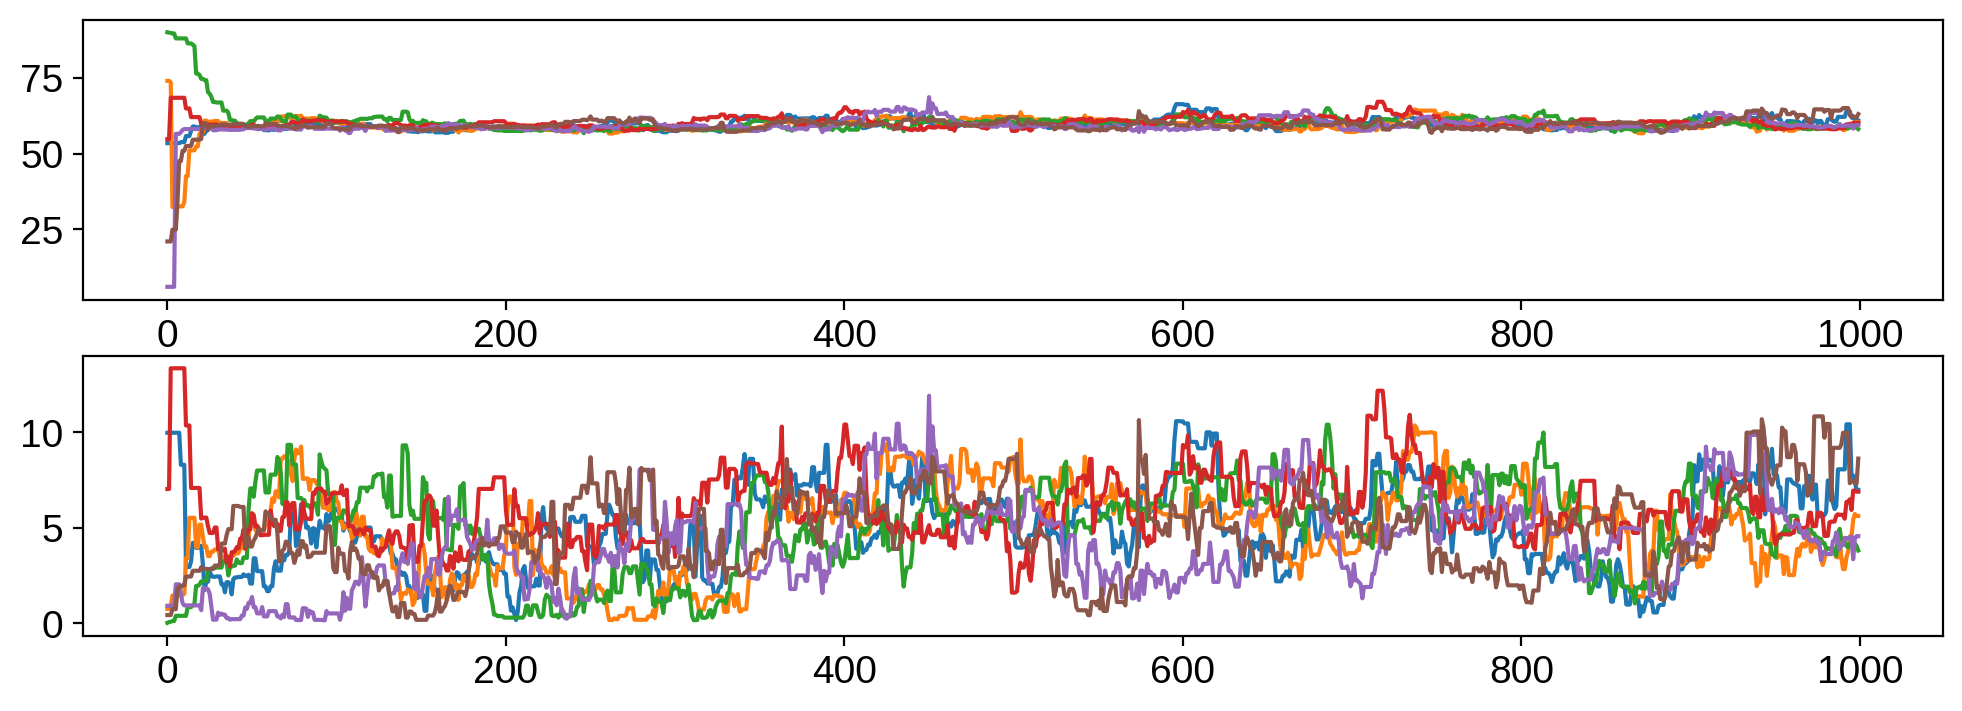

In [21]:
fig, ax = plt.subplots(2)
for k in range(nwalkers):
    ax[0].plot(chain2[k, :, 0])
    ax[1].plot(chain2[k, :, 1])

and, finally, the joint posterior:

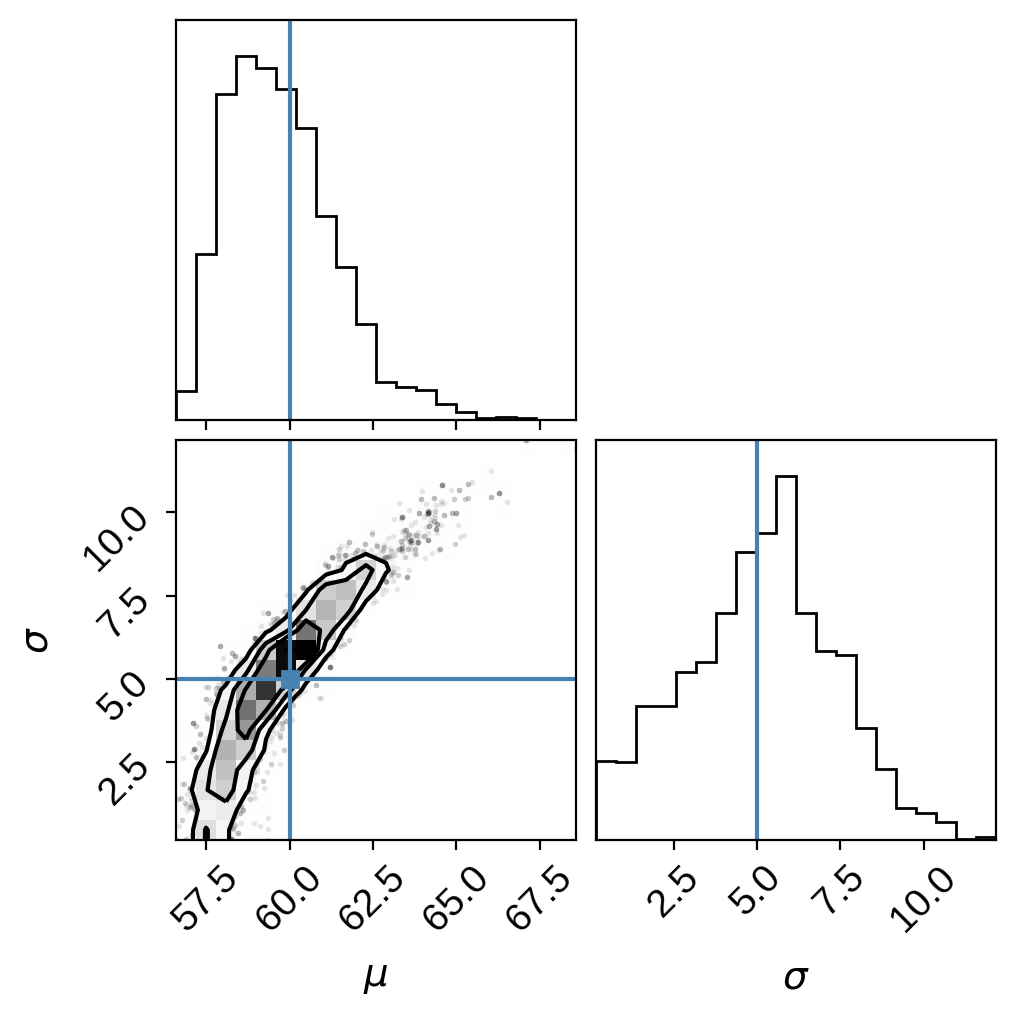

In [22]:
corner(chain2[:, 100:, :].reshape(-1, 2), truths=truths, labels=["$\mu$", "$\sigma$"])
plt.show()

As expected, we get very similar results (keeping in mind the chains are still very far from convergence!)

Bottom line: you can sample in whichever parametrization you want, but we recommend using `a` and `b` as your parameters, as long as you remember to add the Jacobian term to the likelihood.